#**Predicting stocks prices with social media (Reddit) traffic**

##Introduction:

For centuries, traders have tried to predict stock market trends to maximize their profits. The myth says that even the founder of the Rothschild family gained his fortune by using mail pigeons, which allowed him to be the first in London to know that the British won the Waterloo battle, allowing him to purchase English stocks at low prices.

Stock markets today have become extremely complex and interactive. As a result, it is nearly impossible to predict what will happen. In order to gain fractions on small arbitrages, many companies pay fortunes to place their servers physically close to the market.

We are attempting to reduce the problem of stock price forecasting to an easier one in a small case with specific stocks.

Recently, and especially last year (as a result of the Coronavirus), a new phenomenon has emerged. Millions of small investors rely on social media traffic for their investments in the stock market. There is a small list of stocks called "Meme Stocks", which are especially associated with this phenomenon.
Meme stocks are real stocks, that have gained popularity due some online trend in social media, as if the stock has gone viral like a meme.

At the January 2021 a short squeeze of the stock of the American video game retailer GameStop (GME) took place, cuasing major financail consequences and vast changes in the stock's value. At its height, on January 28, the short squeeze caused the retail's stock price to reach a pre-market value of over 500 US$ per share, neary 30 times the valuation of the beginning of the month.

The short squeeze was initially and primarily triggered by users of the subreddit r/wallstreetbets. The unusually high price and volatility have continued after the peak in late January. And, the phenomenon of big amounts of small-scale brokerages using app-based brokerage services such as "Robinhood" that investing by the traffic in social media has expanded. Not only by trading over the GME stock but also on other stock memes.

Our project aims to predict a daily change in meme stock prices based on traffic on Reddit. Specifically on the r/wallstreetbets page. We are focusing on a period of half a 
year, after the GME's short squeeze.

We chose to examine three of the top meme stocks that were in the headlines over the last 2 years: GME (GameStop), AMC (AMC Entertainment) and NOK (Nokia)

### A typical post on a stock in Reddit:
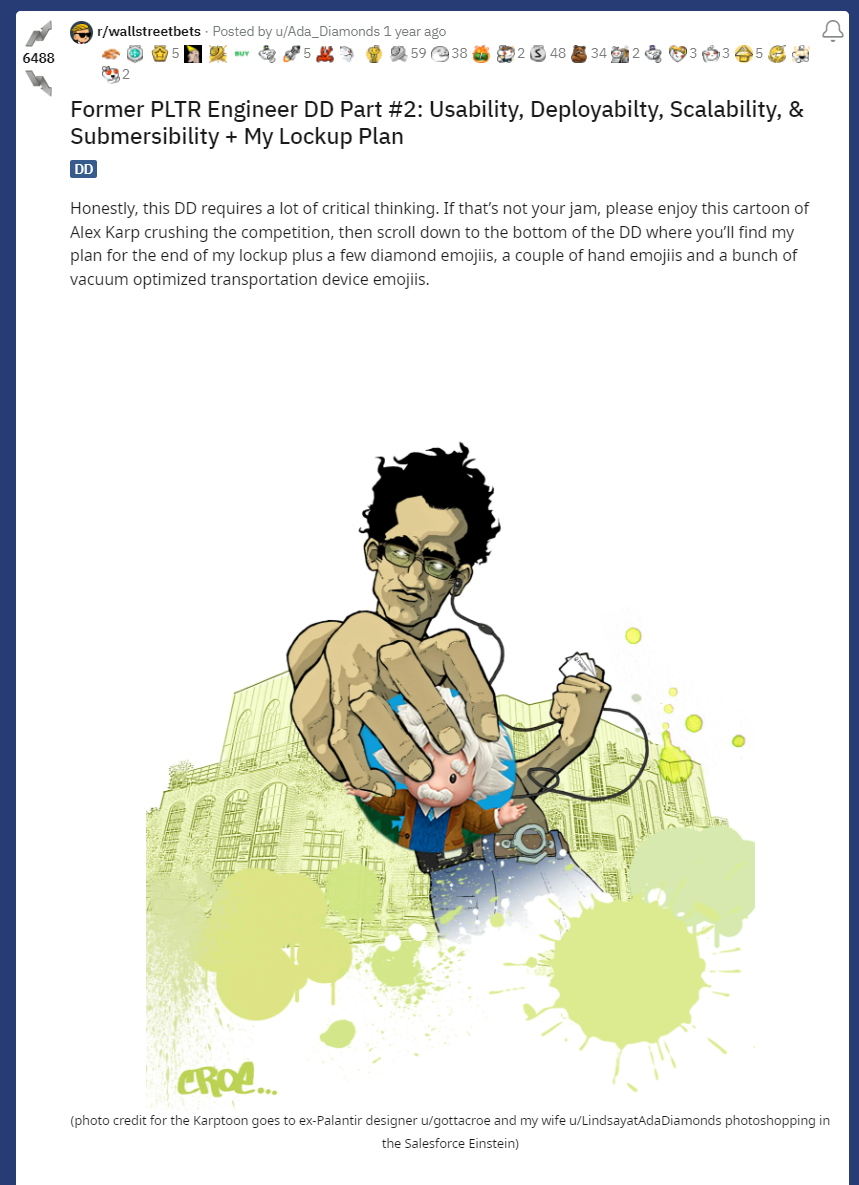

We can see that a post on Reddit typically contains the following data:


*  emojis attached to the posed
*  social media slang language, using many unformal words and emojis.
*  Images, gifs, videos, and links attached to the post,
*  post's score - simply the number of upvotes minus the number of downvotes
*  Number of comments other users wrote in the post 

We will use that data as features and for making new ones for our model



##imports and aux functions

In [1]:
!pip install prophet
!pip install vaderSentiment
!pip install yfinance
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 8.9 MB 27.2 MB/s 
     |████████████████████████████████| 179 kB 71.4 MB/s 
     |████████████████████████████████| 73 kB 2.4 MB/s 
     |████████████████████████████████| 45 kB 1.9 MB/s 
  Attempting uninstall: holidays
    Found existing installation: holidays 0.10.5.2
    Uninstalling holidays-0.10.5.2:
      Successfully uninstalled holidays-0.10.5.2
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.0.4 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev

In [2]:
import shap
from google.colab import drive
from prophet import Prophet
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import warnings
from gensim.models.doc2vec import Doc2Vec
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from wordcloud import WordCloud
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import plotly
import notebook
import ipywidgets
from prophet.plot import plot_plotly, plot_components_plotly
import yfinance as yf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import re
import nltk
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from tqdm import tqdm
import math
import time
import progressbar
nltk.download('stopwords')

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
!pip install transformers
import transformers
from transformers import BertTokenizer, BertModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 31.0 MB/s 
     |████████████████████████████████| 6.6 MB 52.3 MB/s 
     |████████████████████████████████| 596 kB 63.6 MB/s 
     |████████████████████████████████| 101 kB 4.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [4]:
# Utility functions
# function to find max length
def find_max_len(tokenized):
  max_len = 0
  for i in tokenized.values:
      if len(i) > max_len:
          max_len = len(i)
  return max_len
 
 
# function to extract bert features
def get_bert_features(df, text_col):
  tokenized = df[text_col].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))
  max_len = find_max_len(tokenized)
  print("Max Len = ",max_len)
  padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
  attention_mask = np.where(padded != 0, 1, 0)
 
  input_ids = torch.tensor(padded).to(device)
  attention_mask = torch.tensor(attention_mask).to(device)
 
  with torch.no_grad():
    print(input_ids.shape, attention_mask.shape)
    last_hidden_states = model(input_ids, attention_mask=attention_mask)
 
  features = last_hidden_states[0][:,0,:].cpu().numpy()
 
  return features
 
 
# Applying above function in batches to avoid RAM issues
def extract_features(df, text_col, batch_size=1024):
    features = []
    labels = []
 
    no_of_batches = math.ceil(len(df)/batch_size)
    print("\nInitializing...")
    print("Total no of batches : ",str(no_of_batches))
    batch_no = 1
 
    widgets = ['Generating BERT Embeddings: ', progressbar.AnimatedMarker()] 
    bar = progressbar.ProgressBar(max_value=len(df), widgets=widgets).start() 
 
    for i in range (0,len(df),batch_size):
        time.sleep(0.1)
        bar.update(i)
        print()
        print("\nGenerating features for batch",str(batch_no),"of",str(no_of_batches))
        dfn = df[i:i+batch_size]
        tfeatures = get_bert_features(dfn, text_col)
        tfeatures = list(tfeatures)
        features.append(tfeatures)
        batch_no = batch_no + 1
 
    print("Done")
    features = np.concatenate(features)
 
    return features

In [5]:
stopwords.words("english")[:10]
def preprocess_text(text: str, remove_stopwords: bool, tf_idf: bool) -> str:
    """This utility function sanitizes a string by:
    - removing links
    - removing special characters
    - removing numbers
    - removing stopwords
    - transforming in lowercase
    - removing excessive whitespaces
    Args:
        text (str): the input text you want to clean
        remove_stopwords (bool): whether or not to remove stopwords
    Returns:
        str: the cleaned text
    """

    # remove links
    text = re.sub(r"https\S+", "", text)
    # remove special NaNs
    text = re.sub(r"nan", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = nltk.word_tokenize(text)
        # 2. check if stopword
        tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    if tf_idf:
      text = re.sub(r"<sep>", "", text)
      # remove special chars and numbers
      # text = re.sub("[^A-Za-z]+", " ", text)

    return text

In [6]:
def FB_prophet(stock, start_period, training_untill, end_period, days_to_forecast):
  stock_df = yf.Ticker( stock )
  stock_df = stock_df.history(start = start_period, end = end_period)
  stock_df.reset_index(inplace=True)
  stock_df = stock_df[['Date','Close']].rename(columns= {'Date': 'ds', 'Close': 'y'})
  m = Prophet(daily_seasonality=True)
  history_df = stock_df[ stock_df['ds'] <= training_untill ]
  m.fit(history_df)
  future_df = m.make_future_dataframe( periods = days_to_forecast, freq ='d', include_history = True )
  future_df = future_df[ future_df['ds'].isin( stock_df['ds'] ) ]
  return m, m.predict(future_df), stock_df

In [7]:
def multy_ROC_curve_one_graph(y_test, y_score, labels ):
  n_class = 2 if len(y_train[y_train == "no change"]) == 0 else 3
  fpr = {}
  tpr = {}
  thresh ={}
  roc_auc = {}
  colors = ['orange', 'green', 'blue','red','purple','brown', 'pink','gray','olive','cyan']
  for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_score[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i],
             label=( '{0}'.format(labels[i])))
  
  plt.plot([0, 1], [0, 1], color="navy", linestyle="-", label='random clf')
  plt.title('Multiclass ROC curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive rate')
  plt.legend(loc='best')
  plt.figure(figsize=(8, 6), dpi=80)
  plt.show()   

In [8]:
def get_metrices(y_test, prediction):
  cf_matrix = confusion_matrix(y_test, prediction)
  cl_report = classification_report(y_test, prediction)
  acc_score = accuracy_score(y_test, prediction) * 100
  return cf_matrix, cl_report, acc_score

In [9]:
def plot_confusion_matrix(cf_matrix, title):
  fig, ax = plt.subplots(figsize=(15,10))
  ax = sns.heatmap(cf_matrix, annot=True, linewidths=1, cmap='coolwarm', fmt='g', mask=cf_matrix<1)
  ax.set_facecolor('xkcd:black')
  ax.set(title=title)
  ax.plot()

In [10]:
def roc_curve_PC(clf, X_train, y_train):
  clf = OneVsRestClassifier(clf)
  clf = clf.fit(X_train, y_train)
  y_score =clf.predict_proba(X_test)
  labels=['negative', 'positive', 'no change']
  y_b = y_test.apply(lambda x : 0 if x == 'negative' else 1 if x == 'positive' else 2).values
  multy_ROC_curve_one_graph(y_b, y_score, labels)

In [11]:
def stock_date_show(stock_df, stock_name):
  date_to_show = []
  i = 0
  dates_range = len(stock_df)
  while i<=dates_range:
    date_to_show.append(stock_df['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(stock_df['Date'].iloc[dates_range-1])
  x = stock_df['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), stock_df['Open'])
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Stock Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock Values', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [12]:
def normialized_sentiment_value_show(df, stock_df, stock_name):
  date_sentiment_df = pd.DataFrame(df.groupby('timestamp', as_index=False).agg({'sentiment': np.sum}))
  date_sentiment_df.rename(columns={'timestamp': 'Date'}, inplace=True)
  normialized_sentiment_value = date_sentiment_df.merge(pd.DataFrame([stock_df['Date'], stock_df['Open']]).T, on = 'Date')
  normialized_sentiment_value.sentiment = normialized_sentiment_value.sentiment.apply(lambda x:
                                                                                          x/normialized_sentiment_value.sentiment.max() if x >=0 
                                                                                          else -x/normialized_sentiment_value.sentiment.min())
  normialized_sentiment_value.Open = normialized_sentiment_value.Open.apply(lambda x: x/normialized_sentiment_value.Open.max())
  date_to_show = []
  dates_range = len(normialized_sentiment_value)
  i = 0
  while i<dates_range:
    date_to_show.append(normialized_sentiment_value['Date'].iloc[i])
    i += int(dates_range/4)
  date_to_show.append(normialized_sentiment_value['Date'].iloc[dates_range-1])
  x = normialized_sentiment_value['Date']
  plt.figure(figsize=(10,4))
  plt.plot(range(len(x)), normialized_sentiment_value['Open'], label='Opening price')
  plt.plot(range(len(x)), normialized_sentiment_value['sentiment'], label='Daily total sentiment')
  plt.legend(loc='lower right')
  gap = int(dates_range/4)
  plt.xticks(ticks=[0,gap,gap*2,gap*3,gap*4], labels=date_to_show)
  plt.xlabel('Date', fontstyle = 'oblique', fontweight ='bold')
  plt.ylabel('Normalized Value', fontstyle = 'oblique', fontweight ='bold')
  plt.title(f'{stock_name} Stock\n Sentiment VS value', color= 'blue', fontstyle = 'oblique')
  plt.show()

In [13]:
# function to calcualte sentiment of post
def sentiment_scores(sentence):
# Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
# polarity_scores method gives a sentiment dictionary, which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        return 1
    elif sentiment_dict['compound'] <= - 0.05 :
        return -1
    else :
        return 0

In [14]:
def to_corpus(lines):
  for i, line in enumerate(lines):
    tokens = gensim.utils.simple_preprocess(line)
    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

In [15]:
def doc2vec(df):
  # functions to add new columns to df- Doc2Vec.
  GME_combain_text_df = pd.DataFrame(GME_df['title'] + ' ' + GME_df['body'].astype(str), columns=['corpus'])
  GME_combain_text_df['cleaned'] = GME_combain_text_df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=False,tf_idf=False))
  taggetDoc = list(to_corpus(GME_combain_text_df['cleaned'].to_list()))
  modelD2V = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
  modelD2V.build_vocab(taggetDoc)
  modelD2V.train(taggetDoc, total_examples=modelD2V.corpus_count, epochs=modelD2V.epochs)
  df['Doc2Vec'] = GME_combain_text_df['cleaned'].apply(lambda x: modelD2V.infer_vector(x))

In [16]:
def create_text_str(df,combined = True):
  words_df = df[['title','body']]
  words_df['title'] = words_df['title'].str.lower()
  words_df['body'] = words_df['body'].str.lower()
  all_words = pd.concat([words_df['title'].str.split(' '), words_df['body'].str.split(' ')])

  all_words_cleaned = []
  for word in all_words:
    if isinstance(word, float):
      # if no title and no body, it's nan and not iterable
      continue
    text = [x.strip(string.punctuation) for x in word]
    all_words_cleaned.append(text)

  if combined:
    text = [" ".join(text) for text in all_words_cleaned]
    final_text = " ".join(text)
  else:
    final_text = all_words_cleaned
  return final_text

In [17]:
import warnings
warnings.filterwarnings('ignore')

def create_wordclouds(data_frames):
  for df in data_frames:
    final_text = create_text_str(df)
    wordcloud_spam = WordCloud(background_color="white", collocations=False).generate(final_text)
    plt.figure(figsize = (6,6))
    plt.title(df.name)
    plt.imshow(wordcloud_spam, interpolation='bilinear')
    plt.axis("off")

  plt.show()

In [18]:
from datetime import datetime, timedelta
def next_date(str_date):
  return datetime.strftime(datetime.strptime(str_date, '%Y-%m-%d')+ timedelta(1), '%Y-%m-%d')


def PC_of_next_date(str_date):
  if str_date == day_GME_df.sort_values(by='timestamp')['timestamp'].iloc[-1] or str_date == day_GME_df.sort_values(by='timestamp')['timestamp'].iloc[-2]:
    return GME_df['PC'].iloc[-1]
  try:
    x = GME_df[GME_df['timestamp'] == next_date(str_date)]['PC'].iloc[0] 
    y = GME_df[GME_df['timestamp'] == next_date(next_date(str_date))]['PC'].iloc[0] 
    return x if math.isnan(x)==False else y
  except:
    return GME_df['PC'].iloc[-1]
  return x if math.isnan(x)==False else y 

In [19]:

train_losses = []
train_accu = []

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(train_dataloader):
    
    inputs,labels = data[0], data[1]
    
    optimizer.zero_grad()
    outputs=model(inputs)
    loss=loss_fn(outputs,labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(train_dataloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  # print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [128]:
def test(epoch):
  model.eval()
  best_accu = 0
  running_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(test_dataloader):
      inputs,labels=data[0], data[1]
      
      outputs=model(inputs)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss=running_loss/len(test_dataloader)
  accu=100.*correct/total
  if accu > best_accu:
    best_accu = accu
    torch.save(model.state_dict(), './model_weights')

  eval_losses.append(test_loss)
  eval_accu.append(accu)
  print('Test Loss: %.3f | Test Accuracy: %.3f'%(test_loss,accu))

  return best_accu



In [21]:
class StocksDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  
  def __len__(self):
      return len(self.X)
 
  def __getitem__(self,idx):
      return (self.X.values[idx], self.y.values[idx])

##data collection:

###Reddit's dataset


We leverage an existing corpus of r/wallstreetbets posts available on Kaggle
, consisting of all 52,049 posts from
January 2021 through Aug 2021.
Every sample in the datasets contains:
*  The title of the post
*  The score of the post
*  The number of comments users commented over the post
*  The timestamp of the post's creation
*  The body of the post (the message inside it)
*  Technical details over the post

[the dataset from Kaggel](https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts)

In [22]:
#@title importing the dataset from google drive

drive.mount('/content/drive')
posts_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/reddit_wsb.csv')
posts_df.drop(columns=['created','id','url'], inplace=True)
posts_df["timestamp"] = posts_df["timestamp"].str[:10]
posts_day_count = pd.DataFrame(posts_df.groupby('timestamp')['title'].count())
posts_day_count.columns = ["posts_day_count"]
posts_df = posts_df.merge(posts_day_count, left_on="timestamp", right_on="timestamp")

Mounted at /content/drive


In [23]:
#@title Filtering the dataset
GME_posts_df = posts_df[posts_df['title'].str.contains('GME|$GME|gamestop|game stop',case=False) | posts_df['body'].str.contains('GME|$GME|gamestop|game stop',case=False) ]
AMC_posts_df = posts_df[posts_df['title'].str.contains('AMC',case=False) | posts_df['body'].str.contains('AMC',case=False) ]
NOK_posts_df = posts_df[posts_df['title'].str.contains('NOK|nokia',case=False) | posts_df['body'].str.contains('NOK|nokia',case=False)]
print("Columns of every Posts DF: ",list(GME_posts_df.columns))

Columns of every Posts DF:  ['title', 'score', 'comms_num', 'body', 'timestamp', 'posts_day_count']


We filtered the posts dataset to contain only posts regarding the three stocks we chose - GME, AMC, and NOK.
We did that by taking only posts that contain in their title or body a variation of the stock's name. We also added to every post the counting of the number of posts that have been published on its publishing day. For indicating if the post was posted at a "hot" traffic day.

###Stocks' dataset

We used the Yahoo finance api for getting the data over the values of the stocks in the researched period: 2021-01-28 to 2021-08-16.
Every sample in the dataset contains: 
*  **Date** - the day of trading the stock in the stock exchange market
*  **Open** - the price of the stock at the beginning of the day
*  **High** - the maximum value of the stock on this day
*  **Low** - the minimum value of the stock on this day
*  **Close** - the price of the stock at the end of the day
*  **Volume** - the number of shares traded on this day

In [24]:
#@title importing the dataset from google drive
GME_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/GME.csv')
NOK_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/NOK.csv')
AMC_stocks_df = pd.read_csv('/content/drive/MyDrive/memeStocksData/AMC.csv')

###Combined dataset

We used the stocks' dataset and the Reddit's dataset in order to build a combined dataset. We built a new dataset for every stock (GME, AMC, and NOK), by adding the price changes(aka PC) of this day. While we defined the PC as the Open value minus the closing value of the stock on the day the post has been published. This variable is the predicted variable in our project.

In [25]:
#@title building the dataset for every stock
GME_label_df=pd.concat([GME_stocks_df['Date'], pd.DataFrame(GME_stocks_df['Close'] - GME_stocks_df['Open'],columns = ['PC'])], axis = 1)
AMC_label_df=pd.concat([AMC_stocks_df['Date'], pd.DataFrame(AMC_stocks_df['Close'] - AMC_stocks_df['Open'],columns = ['PC'])], axis = 1)
NOK_label_df=pd.concat([NOK_stocks_df['Date'], pd.DataFrame(NOK_stocks_df['Close'] - NOK_stocks_df['Open'],columns = ['PC'])], axis = 1)
GME_df = GME_posts_df.merge(GME_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
AMC_df = AMC_posts_df.merge(AMC_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)
NOK_df = NOK_posts_df.merge(NOK_label_df, left_on="timestamp", right_on="Date", how = 'left').drop('Date', 1)

#####the combined datasets:


In [26]:
#@title GME
GME_df.sample(n=4)

title  score  comms_num  \
13841  Takeaways from the Second GameStop Hearing in ...    607         48   
2755   GameStop was the most traded foreign stock in ...      1          0   
13091  I see your LED desk, I give you my lighting eq...  18073        458   
4441                          Gamestop price too low IMO      1          0   

                                                    body   timestamp  \
13841                                                NaN  2021-03-19   
2755   >MUMBAI (Reuters) - India’s small investors ar...  2021-01-29   
13091                                                NaN  2021-03-10   
4441   They tried all their old moves.  They're tryin...  2021-01-29   

       posts_day_count         PC  
13841              218   4.540008  
2755             15694 -54.709991  
13091              583  -4.429993  
4441             15694 -54.709991

In [27]:
#@title AMC
AMC_df.sample(n=4)

title  score  comms_num  \
1119  CURRENT KNOW PLATFORMS ALLOWING $GME $NOK $BB ...      1          0   
303              Robinhood sold my AMC shares at a loss      3          4   
1659                     Solidarity from The Little Guy      1          0   
4484                        My plan after $AMC and $GME     27         23   

                                                   body   timestamp  \
1119   Vanguard, WeBull, eToro, FreeTrade, Revolut, ...  2021-01-29   
303   I posted a stop less sell for $200 a share yes...  2021-01-29   
1659  Got in late like many of us, couldn't afford G...  2021-01-29   
4484  My plan is to invest quite a bit into FuelCell...  2021-03-06   

      posts_day_count    PC  
1119            15694 -1.05  
303             15694 -1.05  
1659            15694 -1.05  
4484              411   NaN

In [28]:
#@title NOK
NOK_df.sample(n=4)

title  score  comms_num  \
1460      A Consensus on Reasons for Aquiring GME Stock     86        159   
1120  hello! i’m a complete noob to stocks, never re...      1          5   
88    What to do about the spread across GME, NOK, AMC?      0          1   
357                DONT BUY NEW SHIT BUY NOK GME AMC BB     22          5   

                                                   body   timestamp  \
1460  Many of us will be asked in the coming months ...  2021-02-01   
1120  i’m 15 btw, i’m decently broke only have aroun...  2021-01-29   
88    I've been doing some light trading for awhile ...  2021-01-28   
357                                                 NaN  2021-01-29   

      posts_day_count    PC  
1460              884 -0.08  
1120            15694 -0.57  
88               1197 -0.49  
357             15694 -0.57

###Preprocessing the data:

We used NLP technics over the data for augmenting our features based on the data from Reddit. These features will assist us to predict the PC values of the stocks.
WE have used the following technics:
*  **sentiment analysis** - we have used the *VADER* (Valence Aware Dictionary and sEntiment Reasoner) tool. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. We basically classified every post whether positive or negative by using a language model of social media (includes emojis in its vocabulary for example)

*  **embedding** - for the embedding of the title and body of the posts we have used the Doc2Vec tool. Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method. After we have the representation of every post's data as a vector we can use it for ML predicting models.

In [29]:
#@title the preprocessing
try:
  # save time of apply func if already calculated
  GME_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df = pd.read_pickle('/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
except:
  GME_df['sentiment'] = GME_df['title'].apply(sentiment_scores)
  AMC_df['sentiment'] = AMC_df['title'].apply(sentiment_scores)
  NOK_df['sentiment'] = NOK_df['title'].apply(sentiment_scores)
  doc2vec(GME_df)
  doc2vec(AMC_df)
  doc2vec(NOK_df)
  GME_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/GME_df_with_sentiment.pkl')
  AMC_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/AMC_df_with_sentiment.pkl')
  NOK_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/NOK_df_with_sentiment.pkl')
GME_df.name = 'GME'
AMC_df.name = 'AMC'
NOK_df.name = 'NOK'

After the NLP's preprocessing a union of the three data frames looks like the following:

In [30]:
#@title Union df
union_df = pd.concat([GME_df.assign(stock_name="GME"), AMC_df.assign(stock_name="AMC"), NOK_df.assign(stock_name="NOK")])
stocks_df_list = [GME_df, AMC_df, NOK_df]
union_df.sample(n=3)

title  score  comms_num  \
7590  A simpleton's case for why EXPI can go up 100%...      0         10   
5380              Downtrends ... How to deal with them.     28         36   
2717  I am leaving Robinhood after a year, and you s...   1053        246   

                                                   body   timestamp  \
7590  # *This is not financial advice. I eat yellow ...  2021-02-03   
5380  WSB, hi.  You may know me from my previous shi...  2021-08-02   
2717  The coverage of the ban on shares like AMC and...  2021-01-31   

      posts_day_count         PC  sentiment  \
7590             2643 -19.599998          0   
5380               25  -2.380001          0   
2717              939        NaN          0   

                                          Doc2Vec_title  \
7590  [-0.0069332626, 0.008163181, 0.0028487206, -0....   
5380  [0.0057189413, 0.007075897, 0.007600033, -0.00...   
2717  [0.0076155183, -0.006038044, -0.0024157707, 0....   

                                           Doc2Vec_body stock_name  
7590  [0.0022138746, -0.008839865, 0.0037908033, -0....        GME  
5380  [-0.0016361182, -0.00829798, -0.0061354777, -0...        AMC  
2717  [0.007260209, 1.2061155e-05, 0.0026860854, 0.0...        AMC

###Data frames per day

In our project, the question is whether we can predict the value of the stock tomorrow based on the stock history data (yesterday's posts, for example). For that, we need to look at the data also from the perspective of days, so we create for each stock an additional data frame aggregated by days.
In the first step of brute force algorithms, we didn't use the embedded vectors of the posts.
the required day's data frame looks like the following:

In [31]:
#@title day DataFrame
# GME
day_GME_df = GME_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_GME_df[['posts_day_count','PC']] = day_GME_df[['posts_day_count','PC']].div(y)
day_GME_df.name = GME_df.name

# AMC
day_AMC_df = AMC_df.groupby('timestamp', as_index=False).sum()
y = AMC_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_AMC_df[['posts_day_count','PC']] = day_AMC_df[['posts_day_count','PC']].div(y)
day_AMC_df.name = AMC_df.name

# NOK
day_NOK_df = NOK_df.groupby('timestamp', as_index=False).sum()
y = NOK_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_NOK_df[['posts_day_count','PC']] = day_NOK_df[['posts_day_count','PC']].div(y)
day_NOK_df.name = NOK_df.name

#Union day_df of all stocks:
union_day_df = pd.concat([day_GME_df.assign(stock_name="GME"), day_AMC_df.assign(stock_name="AMC"), day_NOK_df.assign(stock_name="NOK")])

# for GME we create also a "day before" df
day_before = day_GME_df
day_before['PC']  = day_before['PC'].shift(-1)

day_before.sample(n=3)

timestamp   score  comms_num  posts_day_count        PC  sentiment
29   2021-02-26  851872     177444            565.0       NaN         49
167  2021-08-09   24454       4100             64.0 -2.309998          2
43   2021-03-12  339897     101931            312.0       NaN         11

##Exploratory data analysis

In [32]:
#@title General Details
for df, day_stocks_df in zip([GME_df, AMC_df, NOK_df], [GME_stocks_df, AMC_stocks_df, NOK_stocks_df]):
  day_stocks_df['dropped/increased'] = day_stocks_df['Close']- day_stocks_df['Open']
  day_stocks_df.loc[day_stocks_df['dropped/increased'] > 0, 'dropped/increased'] = 1
  day_stocks_df.loc[day_stocks_df['dropped/increased'] < 0, 'dropped/increased'] = -1
  print(f"{df.name} Stock data set has {len(df)} lines (line per post). Min posts per day is {min(df['posts_day_count'])}, and Max posts per day is {max(df['posts_day_count'])}\n"
  f"Biggest Price Change in one day was {max(max(df['PC']),abs(min(df['PC']))):.2f}\n"
  f"Number of days {df.name} stock value has increased was {len(day_stocks_df[day_stocks_df['dropped/increased']>0])} and number of days it has dropped was {len(day_stocks_df[day_stocks_df['dropped/increased']<0])}\n")

print(f"\nThe data includes {len(GME_stocks_df)} days.\nThe data frames columns are: {GME_df.columns}")

GME Stock data set has 15058 lines (line per post). Min posts per day is 6, and Max posts per day is 15694
Biggest Price Change in one day was 91.56
Number of days GME stock value has increased was 57 and number of days it has dropped was 81

AMC Stock data set has 5381 lines (line per post). Min posts per day is 6, and Max posts per day is 15694
Biggest Price Change in one day was 7.95
Number of days AMC stock value has increased was 56 and number of days it has dropped was 82

NOK Stock data set has 1945 lines (line per post). Min posts per day is 19, and Max posts per day is 15694
Biggest Price Change in one day was 0.57
Number of days NOK stock value has increased was 58 and number of days it has dropped was 75


The data includes 139 days.
The data frames columns are: Index(['title', 'score', 'comms_num', 'body', 'timestamp', 'posts_day_count',
       'PC', 'sentiment', 'Doc2Vec_title', 'Doc2Vec_body'],
      dtype='object')


We can see that approximatly 40% of the time period the price change of the stock was positive and 60% of the time the price change was negative.

Here are few visual approaches to present our data.
At the end of each of them, we wrote our conclusions, observasions and reaserch questions that came up from it.

### The stocks over time

In [33]:
#@title Stocks Values 2021-01-28 to 2021-08-16:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                    subplot_titles= ['GME - candle sticks plot',
                                     'GME - close value over time'])
fig.add_trace(go.Candlestick(x=GME_stocks_df['Date'],
                open=GME_stocks_df['Open'],
                high=GME_stocks_df['High'],
                low=GME_stocks_df['Low'],
                close=GME_stocks_df['Close']),
              row =1, col=1)

fig.add_trace(go.Scatter(x=GME_stocks_df['Date'],
                         y=GME_stocks_df['Close']),
              row =1, col=2)

fig.update_xaxes(title_text= 'date',
    row =1, col=1)

fig.update_xaxes(title_text= 'date',
    row =1, col=2)
fig.update_layout(showlegend =False, xaxis_rangeslider_visible=False)
fig.show()

fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                    subplot_titles= ['AMC - candle sticks plot',
                                     'AMC - close value over time'])
fig.add_trace(go.Candlestick(x=AMC_stocks_df['Date'],
                open=AMC_stocks_df['Open'],
                high=AMC_stocks_df['High'],
                low=AMC_stocks_df['Low'],
                close=AMC_stocks_df['Close']),
              row =1, col=1)

fig.add_trace(go.Scatter(x=AMC_stocks_df['Date'],
                         y=AMC_stocks_df['Close']),
              row =1, col=2)

fig.update_xaxes(title_text= 'date',
    row =1, col=1)

fig.update_xaxes(title_text= 'date',
    row =1, col=2)
fig.update_layout(showlegend =False,xaxis_rangeslider_visible=False)
fig.show()

fig = make_subplots(rows=1, cols=2, shared_yaxes=True,
                    subplot_titles= ['NOK - candle sticks plot',
                                     'NOK - close value over time'])
fig.add_trace(go.Candlestick(x=NOK_stocks_df['Date'],
                open=NOK_stocks_df['Open'],
                high=NOK_stocks_df['High'],
                low=NOK_stocks_df['Low'],
                close=NOK_stocks_df['Close']),
              row =1, col=1)

fig.add_trace(go.Scatter(x=NOK_stocks_df['Date'],
                         y=NOK_stocks_df['Close']),
              row =1, col=2)

fig.update_xaxes(title_text= 'date',
    row =1, col=1)

fig.update_xaxes(title_text= 'date',
    row =1, col=2)
fig.update_layout(showlegend =False,xaxis_rangeslider_visible=False)
fig.show()

First observation is that all GMA and AMC had at list one segnificant event (dramatic price change) in our dates range. While NOK is more stable.
It is important for our model, in order to be able to learn what social circumstances can cause or relate to such change.

The big story of GME short squeeze happend in January 2021, and our dataset starts at the end of the rapid increase. That is the reason for the big drop at the beginning of GME.
We are wondering rather to expand the dataset, so it contain the whole increase process of GME or to cut it so the it will start straight after it- We think that starting in the middle of the short squeeze might constitute a difficulty for our model to learn.

###Values descriptions:

In [34]:
#@title Bar graph for min max values
stock_names = [stock.name for stock in stocks_df_list]
fig = make_subplots(rows=1, cols=3, subplot_titles=("Max Price Change", "Min Price Change", "Max Post Score"))

# pc max
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['PC'].max() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=1
)

# pc min
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['PC'].min() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=2
)

# score max
fig.add_trace(
    go.Bar(x=stock_names, y=[stock_df['score'].max() for stock_df in stocks_df_list], 
    marker_color=['mediumslateblue', 'lightgreen','lightcoral'],
     hovertemplate ='<i></i>%{y:.2f}<extra></extra>'),
    row=1, col=3
)

fig.update_layout(hovermode="closest",  showlegend=False)
fig.show()

Here we see again that GME changes are more radical, for example in one day the stock value jumped in 60\$, while the maximum raise in NOK was 0.2\$.

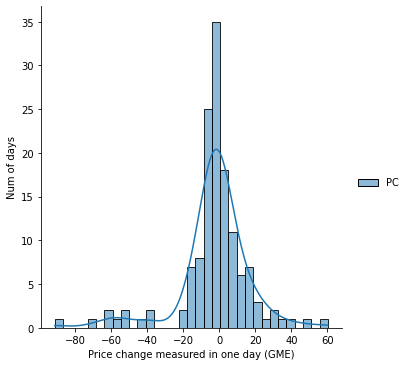

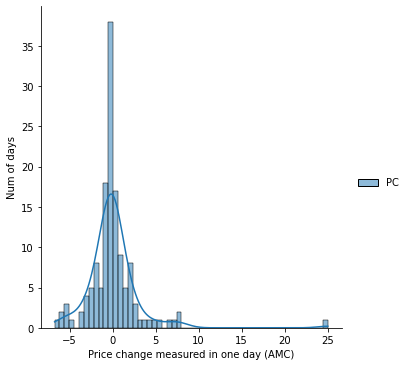

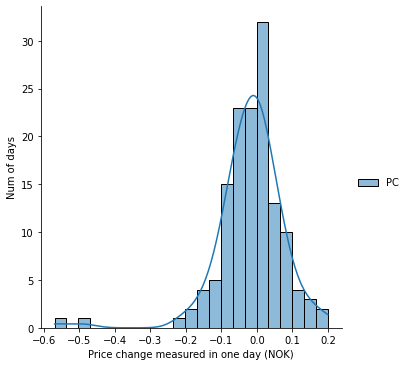

In [35]:
#@title Price Change distribution graph
sns.displot(GME_label_df, kde=True).set_axis_labels("Price change measured in one day (GME)", "Num of days")
sns.displot(AMC_label_df, kde=True).set_axis_labels("Price change measured in one day (AMC)", "Num of days")
sns.displot(NOK_label_df, kde=True).set_axis_labels("Price change measured in one day (NOK)", "Num of days")

We can see that in our 3 chosen stocks, the major changes have been in the GME stock values- it has changes of over 40\$ in one day (and up to -90\$), while the largest change in AMC was 25\$, and for NOK -0.55\$.
We can see again that GME stock "behaves" radically.

###Amount of posts descriptions

First we'll plot a violin graph of each stock for the whole period:

In [36]:
#@title Violin Graph of the whole period
fig = go.Figure()

for stock_df in [day_GME_df, day_AMC_df, day_NOK_df]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))
  fig.update_layout(yaxis_title="Posts in day")

fig.show()

We can see that because of few singles extra ordinary samples the graph gets shrunken.
As we saw before, our data starts with a very radical situation, where the number of comments is very high mainly in GME and AMC. After few days the distribution gets normal (as the *shortsqueeze* ends) as we can see in the violin graph that starts from day 10:

(We also cut part of AMC dates to show a more calm period in details)

In [37]:
#@title Violin Graph from day 10
fig = go.Figure()
df_after_10days_GME = day_GME_df[10:]
df_after_10days_GME.name = day_GME_df.name
df_after_10days_AMC = day_AMC_df[10:90]
df_after_10days_AMC.name = day_AMC_df.name
df_after_10days_NOK = day_NOK_df[10:]
df_after_10days_NOK.name = day_NOK_df.name

for stock_df in [df_after_10days_GME, df_after_10days_AMC, df_after_10days_NOK]:
  fig.add_trace(go.Violin(y=stock_df['posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))
  fig.update_layout(yaxis_title="Posts in day")


fig.show()

Now we can see that after the short squeeze was over, GME still had many days with a high amount of posts per day. AMC and NOK were reduced down to a small number of posts, which can make it difficult to predict their values based on posts. But, because of the high variance in the data, we are still struggling to draw significant conclusions from the data. So, we will present it again in a normalized logarithmic scale for looking at percentage differences between values instead of the actual differences:

In [38]:
#@title Violin Graph from day 10 - Normalized log scaled posts in day
fig = go.Figure()
df_after_10days_GME = day_GME_df[10:]
df_after_10days_GME['log_posts_day_count']= np.log(df_after_10days_GME['posts_day_count'])
df_after_10days_GME['normalized_log_posts_day_count']= (df_after_10days_GME['log_posts_day_count']-df_after_10days_GME['log_posts_day_count'].mean()) / (df_after_10days_GME['log_posts_day_count'].std()+0.000001)
df_after_10days_GME.name = day_GME_df.name
df_after_10days_AMC = day_AMC_df[10:]
df_after_10days_AMC['log_posts_day_count']= np.log(df_after_10days_AMC['posts_day_count'])
df_after_10days_AMC['normalized_log_posts_day_count']= (df_after_10days_AMC['log_posts_day_count']-df_after_10days_AMC['log_posts_day_count'].mean()) / (df_after_10days_AMC['log_posts_day_count'].std()+0.000001)
df_after_10days_AMC.name = day_AMC_df.name
df_after_10days_NOK = day_NOK_df[10:]
df_after_10days_NOK['log_posts_day_count']= np.log(df_after_10days_NOK['posts_day_count'])
df_after_10days_NOK['normalized_log_posts_day_count']= np.log((df_after_10days_NOK['log_posts_day_count']-df_after_10days_NOK['log_posts_day_count'].mean()) / (df_after_10days_NOK['log_posts_day_count'].std()+0.000001))
df_after_10days_NOK.name = day_NOK_df.name

for stock_df in [df_after_10days_GME, df_after_10days_AMC, df_after_10days_NOK]:
  fig.add_trace(go.Violin(y=stock_df['normalized_log_posts_day_count'],
                          name=stock_df.name,
                          box_visible=True,
                          meanline_visible=True))
  fig.update_layout(title="Normalized log scaled posts in day")
  fig.update_layout(yaxis_title="Value")
  fig.update_layout(xaxis_title="Stock")


fig.show()

Now, after presenting the data on a normalized logarithmic scale we can observe a phenomenon we have seen before, after using the FB prophet tool. GME and AMC exhibit similar behavior (with different volumes), while NOKs believer is different:
* Both GME and AMC's interquartile range in the adjusted logarithmic scale are almost the same while NOKs are lower
* Both GME and AMC normalized median and mean in the logarithmic scale are almost the same while NOKs are lower (the median is ~0.85 lower)
* NOK has a few significantly lower values.

In [39]:
#@title Number of posts per stock
dict_posts_num = {}
for stock_df in stocks_df_list:
  dict_posts_num[stock_df.name] = len(stock_df)
fig = px.pie(union_df, values=dict_posts_num, names=dict_posts_num.keys())
fig.update_traces(textinfo='label+value')
fig.update_layout(hovermode=False, title={'text':'Posts number per stock',
        'y':0.95,
        'x':0.49,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

GME has the largest numbers. More posts, bigger changes in stock value and higher max score. Then comes AMC and then NOK.

Therefor, we should analyze and measure each stock according to itself, and not to set general thresholds and limits that applies to all stocks.

###Analyzing pairwise relationships between features

In [40]:
#@title Pairplot graph
fig = px.scatter_matrix(union_day_df, dimensions=["score", "comms_num", "posts_day_count", "sentiment"], color='stock_name', hover_data=["timestamp"])
fig.show()

We can infer few conclusions from the graphs above:


*   As we saw before- GME stock had "more from everything" than AMC and NOK (more posts, total scores..). More data can help for predicting better results.
*   There are few single days that have an extra ordinary data, like a huge number of comments or a big total scores number. Adding the date to each label reveal that they were part of the big *short squeeze* that happened in the end of January 2021.
*   From the sentiment graphs- usually the sentiment of days with a large total sentiment value  is positive. That is, when there are many posts or many comments for posts, usually it goes with a positive post.

###Forecasting values by trends in the stock with FB prophet

We can use FB prophet to approximate past stock prices for predicting future values based on historical trends.
By fitting a linear function, the FB prophet can predict results only by the values we are trying to predict (only the explained variable).

We are testing whether the trend of the stock can be interpolated based solely on its value

#### GME before the "short squeeze"
First, we try to forecast the values of the period after 01/08/2021 (GME's "short squeeze") by interpolating the 3 years before:

In [41]:
#@title without the actual values :

m, forecast, y_gme_df = FB_prophet('GME', '2016-01-01', '2021-01-08', '2021-08-16',365)
fig = plot_plotly(m, forecast)
fig

06:40:48 - cmdstanpy - INFO - Chain [1] start processing
06:40:50 - cmdstanpy - INFO - Chain [1] done processing


We can see that the model can predict well the trends (specific spikes in the values) of this era. Using them, it tries to predict the following half a year.

In [42]:
#@title with the actual values as reference
cutoff_date = '2021-01-08'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]
fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))
config = dict({"scrollZoom":True})
fig.show(config=config)

But, as we can see from the graph above, the next half a year is totally unpredicted by the trends of the years before. 
We know that at the beginning of 2021 a big "short squeeze" took place. 
So, we can see that after it occurred the trends in the stock's value changed and couldn't be predicted by the era before it. 
So, we will try to determine if we can predict spikes in the values by combining data from the time before the "short squeeze" and after it.

#### GME before and after the "short squeeze" 
Furthermore, due to the misfit of the year's before 2021 with 2021's first half a year, we interpolate the values of the period of 16/05/2021 - 16/08/2021 by referring to the data since 01/01/2016.
The point is to see if trends before and after the short squeeze can be related.

In [43]:
#@title with the actual values as refference :

m, forecast, y_gme_df = FB_prophet('GME', '2016-01-01', '2021-05-16', '2021-08-16',200)
fig = plot_plotly(m, forecast)
cutoff_date = '2021-05-16'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]
fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))


fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))



06:40:58 - cmdstanpy - INFO - Chain [1] start processing
06:40:59 - cmdstanpy - INFO - Chain [1] done processing


Observe that the updated interpolation over the combined eras is less accurate than that before the "short squeeze" (predict many unoccurring spikes). Additionally, after the "short squeeze" it predicts only general trends and not the actual rises and drops in value. So, we will try to see if only by fitting data from the time after the "short squeeze" the values can be approximated well and the model can predict actual and future spikes in the stock.

#### GME only after the "short squeeze" 
Last, we try to forecast the values of the period of 16/05/2021 - 16/08/2021 by interpulating with the data since 08/01/2021:

In [44]:
#@title without the actual values :

m, forecast, y_gme_df = FB_prophet('GME', '2021-01-08', '2021-05-10', '2021-08-16',200)
fig = plot_plotly(m, forecast)
cutoff_date = '2021-05-16'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]
fig.add_trace((go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'
    )))

06:41:07 - cmdstanpy - INFO - Chain [1] start processing
06:41:07 - cmdstanpy - INFO - Chain [1] done processing


By looking at the above graph, we can see that, in comparison to the era before the "short squeeze", the era after the "short squeeze" can't be interpolated and modeled with reliable results that can allow us to correctly predict the spikes in the stock. We can conclude from this analysis that the "short squeeze" in GME is an event that changed the behavior of the stock. Since the new behavior is more difficult to predict using only the explained variable (stock's value), it will be interesting to see if we can approximate it using reddit posts as an explanatory variable in this period of time. Hence, if we succeed in doing so over the second period but not the first, this implies that there is a connection between fluctuation in the stock's value and a substantial shock in its price to reddit as an explanation variable.

#### AMC and NOK since 2016  
Analysis of the other stocks of the project - NOK and AMC

In [45]:
#@title AMC :

m, forecast, y_gme_df = FB_prophet('AMC', '2016-01-01', '2021-01-08', '2021-08-16',365)
cutoff_date = '2021-01-08'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]


fig = plot_plotly(m, forecast)
fig.add_trace(go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'))


06:41:12 - cmdstanpy - INFO - Chain [1] start processing
06:41:13 - cmdstanpy - INFO - Chain [1] done processing


In [46]:
#@title NOK :

m, forecast, y_gme_df = FB_prophet('NOK', '2016-01-01', '2021-01-08', '2021-08-16',365)
cutoff_date = '2021-01-08'
history_df = y_gme_df[ y_gme_df['ds'] <= cutoff_date ]
actuals_df = y_gme_df[ y_gme_df['ds'] > cutoff_date ]


fig = plot_plotly(m, forecast)
fig.add_trace(go.Scatter(
        name='Actual',
        x=actuals_df["ds"],
        y=actuals_df["y"],
        marker=dict(color='red', size=4),
        mode='markers'))


06:41:21 - cmdstanpy - INFO - Chain [1] start processing
06:41:21 - cmdstanpy - INFO - Chain [1] done processing


In comparing AMC and NOK shares, we can observe the same rises and drops in value that followed the GME short squeeze of the AMC stock.
On the other hand, we don't see it over NOK. After the short squeeze, both GME and AMC became more volatile, while NOK remained stable. 
The fluctuation of the stock values in this time period, combined with the high volume of traffic on Reddit, suggests that traffic on Reddit has become an explanation for the stock values.

###Normalized Sentiment VS Value

we see a partly correlation between the normalized sentiment and price changes

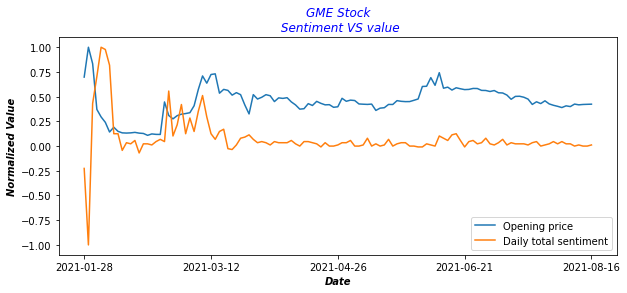

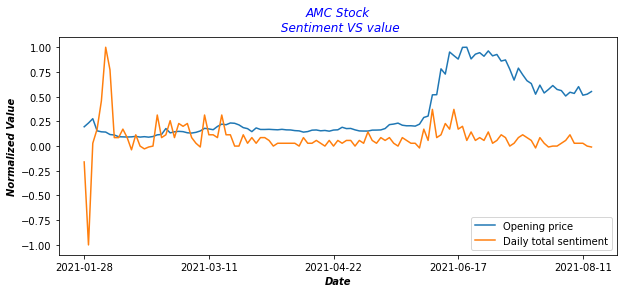

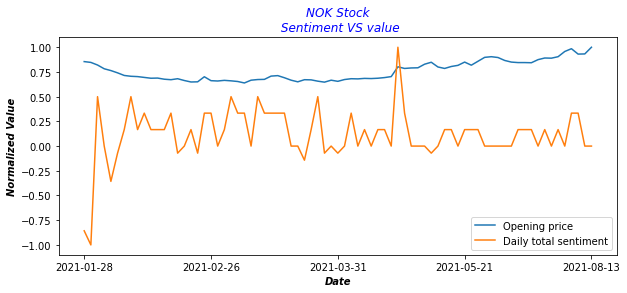

In [47]:
#@title Normalized Sentiment VS Value Graphs
normialized_sentiment_value_show(GME_df, GME_stocks_df, "GME")
normialized_sentiment_value_show(AMC_df, AMC_stocks_df, "AMC")
normialized_sentiment_value_show(NOK_df, NOK_stocks_df, "NOK")

We can see that significant price increasments in GME and AMC (blue curve) are usually accompanied by a strong positive sentiment, and the big drop in GME at the beginning of February 2021 was accompanied by a strong negative sentiment.

In contrast- NOK stock value seems to be more insensitive to sentiments, even though the sentiment differents are less radical. The strongest sentiment for NOK does accompanied by a small value increasment.

Looking at the most common words, we can see that most of them are neutral, and some are even not related to the post saying (like 'http' and 'png').

We cannot say rather we should consider the sentiment feature as a main feature for predicting value change or not, but it worth to test the effect of the post's nerative on our results mainly when it's a strong one- means that in one day, many posts had a clear strong sentiment.

###Textual data analysis

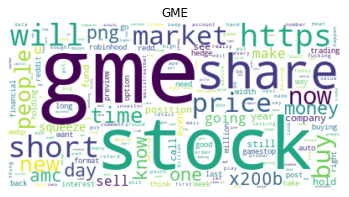

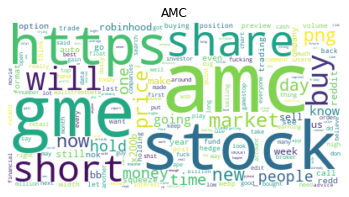

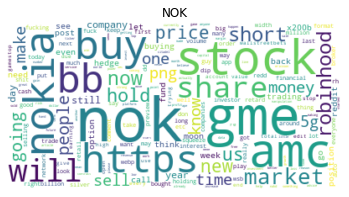

In [48]:
#@title Semantic Distribution
create_wordclouds([GME_df, AMC_df, NOK_df])

Looking at the most common words, we can see that most of them are neutral, and some are even not related to the post saying (like 'http' and 'png').

In [49]:
#@title Average lexical richness
averages = []
AMC_text_flatten = nltk.Text([x for xs in create_text_str(AMC_df, combined=False) for x in xs])
NOK_text_flatten = nltk.Text([x for xs in create_text_str(NOK_df, combined=False) for x in xs])
GME_text_flatten = nltk.Text([x for xs in create_text_str(GME_df, combined=False) for x in xs])
for df_text, df in zip((GME_text_flatten, AMC_text_flatten, NOK_text_flatten),(GME_df, AMC_df, NOK_df)):
  average = len(set(df_text))/len(df_text)
  print(f"{df.name} lexical richness is {average}")

GME lexical richness is 0.04537012411592098
AMC lexical richness is 0.06223169775826932
NOK lexical richness is 0.09001998631322768


We could expect for social media posts to have low lexical richness, since many words repeats themselves (also the stocks names) and many times the are a lot of posts with same meaning, using same words.

In [50]:
#@title Similar words
print("Words with similar range of context to GME:")
GME_text_flatten.similar('gme', 30)
print("\nWords with similar range of context to AMC:")
AMC_text_flatten.similar('amc', 30)
print("\nWords with similar range of context to NOK:")
NOK_text_flatten.similar('nok', 30)

Words with similar range of context to GME:
the it this and that you shares to a amc is gamestop in i but all what
stock robinhood for them at on now of there more us buy they

Words with similar range of context to AMC:
gme the it and this that nok shares you bb is buy hold in on robinhood
to now a i more all what stock them not but there stocks us

Words with similar range of context to NOK:
gme amc bb it nokia and this the buy hold robinhood that is shares in
on you stock now all to not more what nakd why if there or for


We can get 2 main insights from the similar context above.
The first is that often the stocks appear together in the same context. Mainly NOK, usually comes along with the 2 other stocks, and also with BB stock (BlackBerry) that also participant in the famous shortsqueeze.

The second is that many posts include the words "buy" and "hold", as expected- a major goal of the posts is to encourage people to take some action with those stocks.

In [51]:
#@title Collocations
GME_text_flatten.collocation_list(num=30, window_size=3)

[('hedge', 'funds'),
 ('short', 'interest'),
 ('financial', 'advice'),
 ('wall', 'street'),
 ('gme', 'amc'),
 ('hedge', 'fund'),
 ('diamond', 'hands'),
 ('short', 'squeeze'),
 ('retail', 'investors'),
 ('financial', 'advisor'),
 ('pop', 'pop'),
 ('per', 'share'),
 ('market', 'cap'),
 ('gamma', 'squeeze'),
 ('last', 'week'),
 ('long', 'term'),
 ('buy', 'gme'),
 ('market', 'manipulation'),
 ('ryan', 'cohen'),
 ('melvin', 'capital'),
 ('short', 'positions'),
 ('call', 'options'),
 ('loss', 'porn'),
 ('short', 'sellers'),
 ('ladder', 'attacks'),
 ('paper', 'hands'),
 ('amc', 'nok'),
 ('share', 'price'),
 ('make', 'money'),
 ('market', 'makers')]

Again, we see that the stocks often goes together, since 'gme, amc', and 'amc, nok' appears.

But here we can also get a little feeling of the shortsqueeze on GME stock, noticing that one of the pairs is 'buy, gme'. Probably  during the shortsqueeze there were many posts that encourged people to buy GME stocks.

In [52]:
#@title Vocabulay size
print("GME vocab size-", len(GME_text_flatten.vocab()))
print("AMC vocab size-", len(AMC_text_flatten.vocab()))
print("NOK vocab size-", len(NOK_text_flatten.vocab()))

GME vocab size- 123339
AMC vocab size- 49622
NOK vocab size- 19863


We can infer that the size differences are due to the size differences of the data sets.

##Textual Feature Extraction

###feature extraction using tf-idf


before calculating the tf-idf values we are preprocessing the dataset by the following actions :
*  contacting the titles with the body of the posts. using a special word: **< sep >** between the body and the title and omitting it if for the tf-idf.
*  removing links
*  removing the word "nan" that appears where the body is empty.
*  changing all characters to lower case




In [53]:
#@title preprocessed data for tf-idf values  :

GME_combain_text_df = pd.DataFrame(GME_df['title'] + ' <sep> ' + GME_df['body'].astype(str), columns=['corpus'])
GME_combain_text_df['cleaned'] = GME_combain_text_df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=False, tf_idf=True))

AMC_combain_text_df = pd.DataFrame(AMC_df['title'] + ' <sep> ' + AMC_df['body'].astype(str), columns=['corpus'])
AMC_combain_text_df['cleaned'] = AMC_combain_text_df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=False, tf_idf=True))

NOK_combain_text_df = pd.DataFrame(NOK_df['title'] + ' <sep> ' + NOK_df['body'].astype(str), columns=['corpus'])
NOK_combain_text_df['cleaned'] = NOK_combain_text_df['corpus'].apply(lambda x: preprocess_text(x, remove_stopwords=False, tf_idf=True))

GME_combain_text_df.sample(n=3)


corpus  \
5001   Just bought in on this GME dip, see you on the...   
11532  GameStop Frenzy Prompts SEC to Weigh More Shor...   
8886   Epsilon Theory Post on GME, Citadel, etc. Last...   

                                                 cleaned  
5001   just bought in on this gme dip, see you on the...  
11532  gamestop frenzy prompts sec to weigh more shor...  
8886   epsilon theory post on gme, citadel, etc. last...

In [54]:
#@title using KMeans for clustering
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
vectorizer.fit(GME_combain_text_df['cleaned'])
X = vectorizer.transform(GME_combain_text_df['cleaned'])# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the model
kmeans.fit(X)
# store cluster labels in a variable
clusters = kmeans.labels_
GME_combain_text_df['cluster'] = clusters
GME_combain_text_df.sample(5)



corpus  \
10572  Why is SPCE (Virgin Galactic) not part of the ...   
12981         GME - I think I like this stock! <sep> nan   
7154   How to give Robinhood a Red Dildo (hint: don't...   
11634  DD: HIMAX TECHNOLOGIES $HIMX = 🍗🚀 💦 LOTS OF PI...   
11812  $NVDA Long Thesis <sep> It’s been a crazy past...   

                                                 cleaned  cluster  
10572  why is spce (virgin galactic) not part of the ...        2  
12981                  gme - i think i like this stock!         1  
7154   how to give robinhood a red dildo (hint: don't...        2  
11634  dd: himax technologies $himx = 🍗🚀 💦 lots of pi...        2  
11812  $nvda long thesis  it’s been a crazy past week...        2

In [55]:
#@title top keywords in every cluster
def get_top_keywords(n_terms):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(10)


Cluster 0
robinhood,hold,the,nok,to,bb,and,gme,buy,amc

Cluster 1
is,in,of,gamestop,and,on,my,to,the,gme

Cluster 2
in,you,this,it,that,is,of,and,to,the


it's hard to understand what is the subjects for the tf-idf clustering by examples and the top keywords. But, it seems that cluster 2 is the most different one. his top keywords are mostly conjunctions and it seems that his posts are more general and descriptive ones. also, we can see that cluster 1 has keywords related to the stocks but cluster 0 is the only one that has actual directives in its keywords ("buy" and "hold"). therefore, they both may relate to specific posts and events but cluster 0 is more about actual actions like buying, holding, and selling.

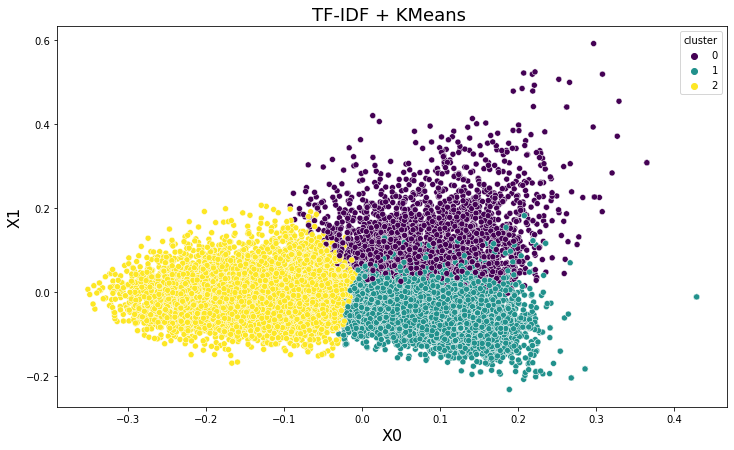

In [56]:
#@title using PCA for visualising the clustering
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X.toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
GME_combain_text_df['x0'] = x0
GME_combain_text_df['x1'] = x1
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans ", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=GME_combain_text_df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

the PCA results are becking our suggestion - we can see a good separation from the most distinguished cluster - cluster 2 from the other clusters. and we can detect also a separation between clusters 0 and 1 but it is lesser than from those 2 clusters to cluster 1. it seems that the tf-idf is a good feature that can be used in the classic ML models.

###Clustering Doc2Vec embedding 

Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method. We are using a neural network for the embedding of every word in the post and then use it for the embedding of the words for one vector representation of the text.

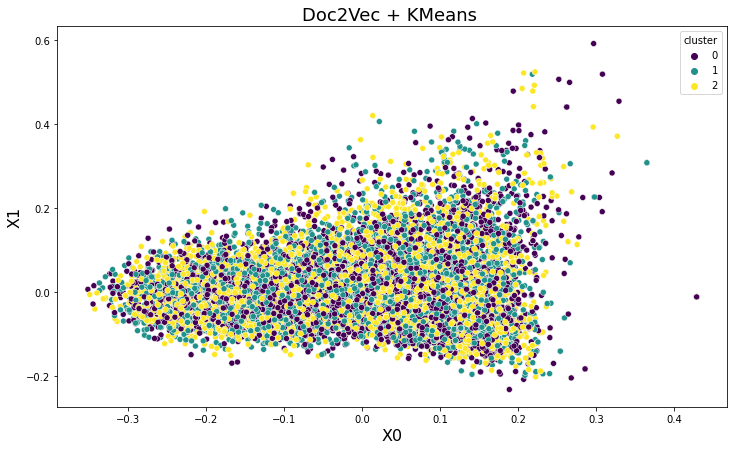

In [57]:
#@title Doc2Vec clustering
kmeans.fit(GME_df['Doc2Vec_title'].tolist())
clusters = kmeans.labels_
pca.fit_transform(GME_df['Doc2Vec_title'].tolist())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
GME_combain_text_df['cluster'] = clusters
GME_combain_text_df['x0'] = x0
GME_combain_text_df['x1'] = x1
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Doc2Vec + KMeans ", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=GME_combain_text_df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

After lowering the dimension of the clustering we can see that over 2 dimensions we can't see a good separation over the clusters. But, it doesn't mean for certain that the embedding and the clustering don't good because we lose information in the PCA process, and therefore it could have influenced a good clustering.

###Feature Extraction using transformers

Because of the big amount of resources required to train an NLP transformer we will use the state-of-the-art model of BERT. Bidirectional Encoder Representations from Transformers (BERT) is a transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google.

BERT is at its core a transformer language model with a variable number of encoder layers and self-attention heads We will use the pre-trained encoder of BERT for extracting features of the post's text.

Bert was trained over sentences of 512 words. Therefore it's restricted to sentences of a maximum length of 512. So, we will use it over the titles of the posts.

In [58]:
#@title using BERT for feature extracting

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_class, tokenizer_class, pretrained_weights = (BertModel, BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights).to(device)

#GME
features = extract_features(df=GME_df, text_col = 'title', batch_size=1024)
GME_embeddings = list(features)
GME_df['bert_features'] = GME_embeddings

#AMC
features = extract_features(df=AMC_df, text_col = 'title', batch_size=1024)
AMC_embeddings = list(features)
AMC_df['bert_features'] = AMC_embeddings

#NOK
features = extract_features(df=NOK_df, text_col = 'title', batch_size=1024)
NOK_embeddings = list(features)
NOK_df['bert_features'] = NOK_embeddings

GME_df[['timestamp','title','body','sentiment','bert_features']].sample(5)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Generating BERT Embeddings: /                                                  


Initializing...
Total no of batches :  15


Generating features for batch 1 of 15
Max Len =  78
torch.Size([1024, 78]) torch.Size([1024, 78])


Generating BERT Embeddings: -                                                  



Generating features for batch 2 of 15
Max Len =  85
torch.Size([1024, 85]) torch.Size([1024, 85])


Generating BERT Embeddings: \                                                  



Generating features for batch 3 of 15
Max Len =  146
torch.Size([1024, 146]) torch.Size([1024, 146])


Generating BERT Embeddings: |                                                  



Generating features for batch 4 of 15
Max Len =  101
torch.Size([1024, 101]) torch.Size([1024, 101])


Generating BERT Embeddings: /                                                  



Generating features for batch 5 of 15
Max Len =  78
torch.Size([1024, 78]) torch.Size([1024, 78])


Generating BERT Embeddings: -                                                  



Generating features for batch 6 of 15
Max Len =  81
torch.Size([1024, 81]) torch.Size([1024, 81])


Generating BERT Embeddings: \                                                  



Generating features for batch 7 of 15
Max Len =  82
torch.Size([1024, 82]) torch.Size([1024, 82])


Generating BERT Embeddings: |                                                  



Generating features for batch 8 of 15
Max Len =  90
torch.Size([1024, 90]) torch.Size([1024, 90])


Generating BERT Embeddings: /                                                  



Generating features for batch 9 of 15
Max Len =  88
torch.Size([1024, 88]) torch.Size([1024, 88])


Generating BERT Embeddings: -                                                  



Generating features for batch 10 of 15
Max Len =  82
torch.Size([1024, 82]) torch.Size([1024, 82])


Generating BERT Embeddings: \                                                  



Generating features for batch 11 of 15
Max Len =  79
torch.Size([1024, 79]) torch.Size([1024, 79])


Generating BERT Embeddings: |                                                  



Generating features for batch 12 of 15
Max Len =  79
torch.Size([1024, 79]) torch.Size([1024, 79])


Generating BERT Embeddings: /                                                  



Generating features for batch 13 of 15
Max Len =  97
torch.Size([1024, 97]) torch.Size([1024, 97])


Generating BERT Embeddings: -                                                  



Generating features for batch 14 of 15
Max Len =  80
torch.Size([1024, 80]) torch.Size([1024, 80])


Generating BERT Embeddings: \                                                  



Generating features for batch 15 of 15
Max Len =  85
torch.Size([722, 85]) torch.Size([722, 85])


Generating BERT Embeddings: /                                                  

Done

Initializing...
Total no of batches :  6


Generating features for batch 1 of 6
Max Len =  85
torch.Size([1024, 85]) torch.Size([1024, 85])


Generating BERT Embeddings: -                                                  



Generating features for batch 2 of 6
Max Len =  104
torch.Size([1024, 104]) torch.Size([1024, 104])


Generating BERT Embeddings: \                                                  



Generating features for batch 3 of 6
Max Len =  86
torch.Size([1024, 86]) torch.Size([1024, 86])


Generating BERT Embeddings: |                                                  



Generating features for batch 4 of 6
Max Len =  88
torch.Size([1024, 88]) torch.Size([1024, 88])


Generating BERT Embeddings: /                                                  



Generating features for batch 5 of 6
Max Len =  81
torch.Size([1024, 81]) torch.Size([1024, 81])


Generating BERT Embeddings: -                                                  



Generating features for batch 6 of 6
Max Len =  76
torch.Size([261, 76]) torch.Size([261, 76])


Generating BERT Embeddings: /                                                  

Done

Initializing...
Total no of batches :  2


Generating features for batch 1 of 2
Max Len =  85
torch.Size([1024, 85]) torch.Size([1024, 85])


Generating BERT Embeddings: -                                                  



Generating features for batch 2 of 2
Max Len =  101
torch.Size([921, 101]) torch.Size([921, 101])
Done


timestamp                                              title  \
8556   2021-02-04        Knew From The Beginning Everyone Would Sell   
9237   2021-02-05  Robinhood lifts trading restrictions on GameSt...   
7160   2021-02-02  Fake News, Hedge Funds and why the media is a ...   
10815  2021-02-07                           Be careful, danger ahead   
203    2021-01-28                 Robinhood disables AMC, GME buying   

                                                    body  sentiment  \
8556   I told everyone that I knew not to waste their...          0   
9237                                                 NaN          0   
7160   So what the fuck is going on right? \n\nThursd...         -1   
10815  Although GameStop has exposed a problematic sy...         -1   
203                                                  NaN          0   

                                           bert_features  
8556   [-0.03382035, 0.20894882, 0.08059607, 0.073054...  
9237   [-0.6035533, 0.11877969, -0.23749636, -0.26165...  
7160   [0.06688266, 0.21557505, -0.42133018, 0.091185...  
10815  [-0.06325456, 0.13810058, -0.18456553, 0.10208...  
203    [-0.48654762, -0.18698946, -0.21348205, -0.314...

In [59]:
#@title clustering BERT features
X_b = GME_df['bert_features']
kmeans = KMeans(n_clusters=3, random_state=42)
# fit the mode
kmeans.fit(X_b.to_list())
# store cluster labels in a variable
clusters = kmeans.labels_
GME_df['bert_cluster'] = clusters
GME_df[['timestamp','title','sentiment','bert_cluster']].sample(5)


timestamp                                              title  \
3341   2021-01-29  The elite class of the American capitalist emp...   
5645   2021-01-30  Idea - Aggregating different models to track G...   
14361  2021-04-14  Just bought 5 more shares and now I have 100. ...   
11418  2021-02-13  I’m 19 years old and just bought 5,400 more $G...   
10732  2021-02-06  If you hold GME for a loss just claim it as a ...   

       sentiment  bert_cluster  
3341          -1             2  
5645           1             1  
14361          1             2  
11418          0             2  
10732         -1             0

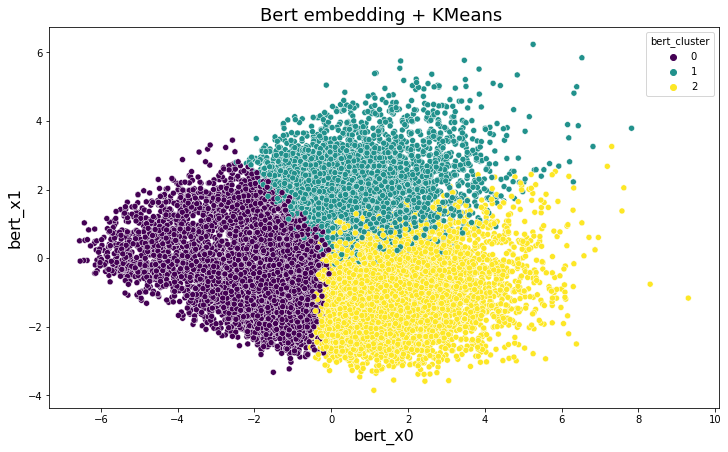

In [60]:
#@title using PCA for visualising the clustering

# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X_b.to_list())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]
GME_df['bert_cluster'] = clusters
GME_df['bert_x0'] = x0
GME_df['bert_x1'] = x1
# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("Bert embedding + KMeans ", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("bert_x0", fontdict={"fontsize": 16})
plt.ylabel("bert_x1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=GME_df, x='bert_x0', y='bert_x1', hue='bert_cluster', palette="viridis")
plt.show()

The clustering of the Bert features over 2 dimentions looks very good (in terms of separation).
Also, Bert is a state of the art model. Therefore we will prefer it's embadding over the Doc2Vec's.

##Predictions

####We are trying to predict the next day's price change (trend) in the stock, by analyzing the previous day's posts on Reddit.
we will evaluate which is the best model over GME and afterward will check it over AMC and NOK

###Statistics and Classic ML over the featured df

In [61]:
#@title Dataframe for the predictions:
#GME
'''temp = pd.DataFrame(GME_df[GME_df['PC'].isna()]['timestamp'].apply(lambda x: PC_of_next_date(x)))
temp.columns=['PC']
GME_df = GME_df.combine_first(temp)'''
GME_df['tf-idf'] = pd.DataFrame(X.todense()).T.apply(lambda x: x.sum())
day_GME_df = GME_df.groupby('timestamp', as_index=False).sum()
y = GME_df.groupby('timestamp', as_index=False)[['posts_day_count','PC']].count().drop(columns='timestamp')
day_GME_df[['posts_day_count','PC']] = day_GME_df[['posts_day_count','PC']].div(y)
day_before_GME = day_GME_df.copy()
day_before_GME['PC']  = day_GME_df['PC'].shift(-1)
day_before_GME.drop(['bert_cluster','bert_x0','bert_x1'],axis=1, inplace=True)

#AMC
AMC_df['tf-idf'] = pd.DataFrame(X.todense()).T.apply(lambda x: x.sum())
day_AMC_df = AMC_df.groupby('timestamp', as_index=False).sum()
y = AMC_df.groupby('timestamp', as_index=False)[['score','comms_num','posts_day_count','PC','tf-idf']].count().drop(columns='timestamp')
day_AMC_df[['score','comms_num','posts_day_count','PC','tf-idf']] = day_AMC_df[['score','comms_num','posts_day_count','PC','tf-idf']].div(y)
day_AMC_df.name = AMC_df.name
day_before_AMC = day_AMC_df
day_before_AMC['PC']  = day_before_AMC['PC'].shift(-1)

#NOK
NOK_df['tf-idf'] = pd.DataFrame(X.todense()).T.apply(lambda x: x.sum())
day_NOK_df = NOK_df.groupby('timestamp', as_index=False).sum()
y = NOK_df.groupby('timestamp', as_index=False)[['score','comms_num','posts_day_count','PC','tf-idf']].count().drop(columns='timestamp')
day_NOK_df[['score','comms_num','posts_day_count','PC','tf-idf']] = day_NOK_df[['score','comms_num','posts_day_count','PC','tf-idf']].div(y)
day_NOK_df.name = NOK_df.name
day_before_NOK = day_NOK_df
day_before_NOK['PC']  = day_before_AMC['PC'].shift(-1)

day_before_GME.sample(n=3)


timestamp  score  comms_num  posts_day_count        PC  sentiment  \
169  2021-08-11    108        179             91.0  2.470001          1   
149  2021-07-10    379        244             53.0       NaN          1   
97   2021-05-08  18819       2392            126.0       NaN          6   

         tf-idf  
169   33.173019  
149   40.168753  
97   150.554399

#### Analitical Regressions

First, we used linear and logistic regression to analyze the connection between the features and the stock's price change. 

##### Linear Regression

######First Model

We started with a simple linear regression model:

$PC_{day_{i+1}}= α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}+α_4*tf-idf_{day_i}$


while:

* $score_{day_i}$ : sum of scores of all posts in day i over GME in r/wallstreetbets channel. the score of a post is determined by the number of upvotes (likes) minus the number of downvots (dislikes) upon the post .

* $comms_{day_i}$ : sum of all the comments over all the posts in day i over GME in r/wallstreetbets channel

* $posts_{day_i}$ : number of posts posted in day i over GME in r/wallstreetbets channel

* $sentiment_{day_i}$ : sum of all sentiments score determined by VADER of posts posted in day i over GME in r/wallstreetbets 

* $PC_{day_{i+1}}$ : Price changes (open - close) in the GME stock's value on day i+1 (predicted variable)




In [62]:
#@title Linear Regression basic model
linear_df = day_before_GME.dropna().copy(deep=True)
linear_df.drop(['timestamp'], axis=1, inplace=True)
model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PC   R-squared (uncentered):                   0.264
Model:                            OLS   Adj. R-squared (uncentered):              0.232
Method:                 Least Squares   F-statistic:                              8.262
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                    1.07e-06
Time:                        06:45:30   Log-Likelihood:                         -510.56
No. Observations:                 120   AIC:                                      1031.
Df Residuals:                     115   BIC:                                      1045.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
score           -5.405e-05   2.03e-05     -2.656      0.009   -9.44e-05   -1.37e-05
comms_num           0.0002   7.87e-05      1.995      0.048    1.15e-06       0.000
posts_day_count    -0.0153      0.019     -0.805      0.422      -0.053       0.022
sentiment           0.5094      0.187      2.729      0.007       0.140       0.879
tf-idf             -0.0028      0.009     -0.296      0.768      -0.021       0.016
==============================================================================
Omnibus:                       17.514   Durbin-Watson:                   2.310
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               76.179
Skew:                          -0.135   Prob(JB):                     2.87e-17
Kurtosis:                       6.894   Cond. No.                     3.22e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.22e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We can see high levels of significance in both t values and F values. Therefore, the features have a high probability of being relevant for the predictions. But, the $R^2$ score is 0.264 which is low. So, the simple model isn't complex enough to predict the PC with efficient accuracy. To improve accuracy, we will try a more complex model with more features.


######second model

$PC_{day_{i+1}}=α_0*score_{day_i}+α_1*comms_{day_i}+α_2*posts_{day_i}+α_3*sentiment_{day_i}+α_4*score_{day_i}*sentiment_{day_i}+α_5*comms_{day_i}*sentiment_{day_i}+α_6*posts_{day_i}*sentiment_{day_i}+α_7*posts_{day_i}^2+α_8*sentiment_{day_i}^2+α_9*score_{day_i}^2+α_{10}*comms_{day_i}^2+α_{11}*tf-idf_{day_i}$

We added interactions between every two initial features and polyinomial features to each feature in order to allow the model to integrate interactions between features and polynomial effects. 

In [63]:
#@title linear regrrestion complax model
linear_df['sentiment*score'] = linear_df['sentiment']*linear_df['score']
linear_df['sentiment*comms_num'] = linear_df['sentiment']*linear_df['comms_num']
linear_df['posts_day_count*sentiment'] = linear_df['posts_day_count']*linear_df['sentiment']
linear_df['posts_day_count**2'] = linear_df['posts_day_count']**2
linear_df['sentiment**2'] = linear_df['sentiment']**2
linear_df['score**2'] = linear_df['score']**2
linear_df['comms_num**2'] = linear_df['comms_num']**2

model = sm.OLS(linear_df['PC'],linear_df.drop(['PC'], axis=1))
results = model.fit()
results.params
r = np.ones_like(results.params)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     PC   R-squared (uncentered):                   0.358
Model:                            OLS   Adj. R-squared (uncentered):              0.286
Method:                 Least Squares   F-statistic:                              5.012
Date:                Fri, 15 Jul 2022   Prob (F-statistic):                    1.45e-06
Time:                        06:45:30   Log-Likelihood:                         -502.42
No. Observations:                 120   AIC:                                      1029.
Df Residuals:                     108   BIC:                                      1062.
Df Model:                          12                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
score                      2.539e-05   3.48e-05      0.729      0.467   -4.36e-05    9.44e-05
comms_num                  2.786e-05      0.000      0.193      0.848      -0.000       0.000
posts_day_count              -0.0025      0.026     -0.093      0.926      -0.055       0.050
sentiment                    -1.0332      0.578     -1.788      0.077      -2.179       0.112
tf-idf                        0.0042      0.013      0.329      0.743      -0.021       0.029
sentiment*score           -1.357e-06    3.2e-06     -0.424      0.672    -7.7e-06    4.98e-06
sentiment*comms_num        8.081e-06   5.84e-06      1.384      0.169   -3.49e-06    1.97e-05
posts_day_count*sentiment     0.0011      0.001      1.647      0.102      -0.000       0.003
posts_day_count**2        -5.171e-05   2.33e-05     -2.216      0.029    -9.8e-05   -5.46e-06
sentiment**2                  0.0117      0.016      0.749      0.455      -0.019       0.043
score**2                  -3.032e-11   7.35e-11     -0.413      0.681   -1.76e-10    1.15e-10
comms_num**2              -1.261e-10   9.65e-10     -0.131      0.896   -2.04e-09    1.79e-09
==============================================================================
Omnibus:                       27.124   Durbin-Watson:                   2.306
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              124.631
Skew:                          -0.580   Prob(JB):                     8.64e-28
Kurtosis:                       7.856   Cond. No.                     1.20e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In terms of statistical significance, the F value is still significant within a confidence interval of 95%. So, the model is relevant for predicting PC value. But, the T value of every feature except the $posts^2$ is not high enough. So in terms of analysing the features, we can only assume that the influence of the number of posts in a day isn't linear. And, can't know the exact relevance of the other features in the model.
We can also see an improvement in the accuracy score ($R^2$) to 0.357 as we wanted to achieve.

#####Logistic Regression

After getting maximum accuracy of 0.357 with the linear regression we turn to a logistic regression model. With it we can only classify to classes - negative, positive or natural PC value. So we are taking the second, more complax model, from before and change the predicted values into classes.

In [64]:
#@title Logistic regression resualts

logistic_df = linear_df.copy(deep=True)
logistic_df['PC']= logistic_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
logistic_df.dropna(inplace=True)
x = logistic_df.drop(['PC'], axis=1)
y = logistic_df['PC']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
clf = LogisticRegression(random_state=0).fit(x, y)
clf.score(X_test, y_test)

0.625

We have a significant improvement in the accuracy score from the linear model (0.625 VS 0.357). Thus, simply classifying the trend in a stock's value is likely easier than trying to predict the exact price movements. 

####Classifying models

After using analitical regressions over the data we turn to use a classical simple classfiing algorithms:
* Random Forest (RF)
* k nearest neighbors (KNN)
* Support vector machine (SVM)

To let the algorithms extract features from the clean data frame, we return to the clean data frame with it classifying to classes version.

In [65]:
#@title dataframe for classification

cls_df = day_before_GME.dropna().copy(deep=True)
cls_df['PC']= cls_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
cls_df.drop(['timestamp'], axis=1, inplace=True)
cls_df.dropna(inplace=True)
x = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
cls_df.sample(n=4)

score  comms_num  posts_day_count        PC  sentiment      tf-idf
169    108        179             91.0  positive          1   33.173019
114    323         85             89.0  positive         -1   31.660107
69   46659      22521             66.0  negative          3  146.280553
153   6466        617             75.0  positive          1   26.251242

In [66]:
#@title Random Forest results

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.5833333333333334

In [67]:
#@title SVM results

from sklearn import svm

clf = svm.SVC(kernel="rbf", C=0.1, probability=True)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.625

In [68]:
#@title KNN results

knn = KNeighborsClassifier(8)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.7916666666666666

We are getting the highest score with KNN (o.792 VS 0.625 and 0.583).

#####KNN roc and report:

To learn more about the problem, we are analyzing the most accurate classifier results (KNN):



In [69]:
#@title KNN report:

y_pred = knn.predict(X_test)
knn_cf_matrix, knn_cl_report, knn_acc_score = get_metrices(y_test,y_pred)
print(knn_cl_report)

              precision    recall  f1-score   support

    negative       0.86      0.80      0.83        15
    positive       0.70      0.78      0.74         9

    accuracy                           0.79        24
   macro avg       0.78      0.79      0.78        24
weighted avg       0.80      0.79      0.79        24



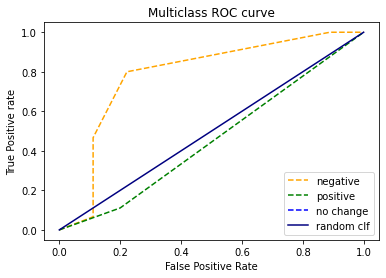

<Figure size 640x480 with 0 Axes>

In [70]:
#@title KNN ROC curve

roc_curve_PC(knn, X_train, y_train)

In [71]:
#@title KNNs SHAP force plot
shap.initjs()
explainer = shap.KernelExplainer(knn.predict_proba, X_train)
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/24 [00:00<?, ?it/s]

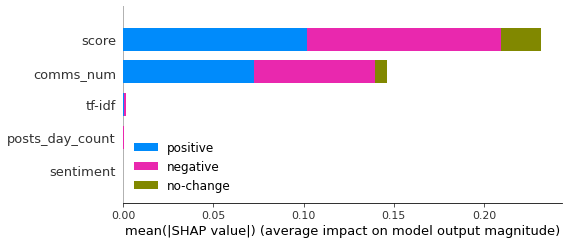

In [72]:
#@title KNNs SHAP summery plot
shap.summary_plot(shap_values = shap_values, features = X_train.columns, class_names = ['negative', 'no-change','positive'])

We can see that the algorithm can predict with more precision negative trends in the stock price than positive ones. This can suggest a stronger relationship between a decrease in stock value and the Reddit posts than an increase in stock value. But, it could also be connected to the fact that our database is limited to a specific period and specifically lacks the initiation of the GME frenzy.

Also, by the SHAP results, we can see that the most significant features are the score and number of comments on a post

###predicting with DNN(deep neural network) CLF and explaning the resualts with SHAP

In [137]:
#@title Adding the embedding features to the data frame 

GME_embedding_df = pd.concat([GME_df, pd.DataFrame(GME_embeddings)], axis=1)
GME_embedding_df.name = 'GME'
#GME_embedding_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/GME_embedding_df.pkl')
day_GME_df = GME_embedding_df.groupby('timestamp', as_index=False).sum()
y = GME_embedding_df.groupby('timestamp', as_index=False)[['score','comms_num','posts_day_count','PC','tf-idf']].count().drop(columns='timestamp')
day_GME_df[['score','comms_num','posts_day_count','PC','tf-idf']] = day_GME_df[['score','comms_num','posts_day_count','PC','tf-idf']].div(y)
day_GME_df.name = GME_embedding_df.name
day_before_GME = day_GME_df.copy()
day_before_GME['PC']  = day_before_GME['PC'].shift(-1)
day_before_GME.drop(['bert_cluster','bert_x0','bert_x1','timestamp'],axis=1, inplace=True)

cls_df = day_before_GME.copy(deep=True).astype(np.float32)
cls_df['PC']= cls_df['PC'].apply(lambda x: 0 if x>0 else 1 if x<0 else 2 if x==0 else None)
cls_df.dropna(inplace=True)
X = cls_df.drop(['PC'], axis=1)
y = cls_df['PC'].astype(np.longlong)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
cls_df.sample(n=4)


score    comms_num  posts_day_count   PC  sentiment     tf-idf  \
74   5189.454590  3360.272705             47.0  1.0        2.0   8.410974   
59  15396.941406   353.235291             48.0  0.0        8.0   6.936267   
35   1267.312012   470.511993            475.0  0.0       11.0   9.109371   
81   4460.500000   449.500000             23.0  1.0        2.0  11.832525   

            0         1         2         3  ...       758        759  \
74  -2.924782 -2.120360  0.085875  0.277831  ...  1.036183  -1.027060   
59  -2.751947 -0.491078  2.084781 -1.601834  ... -2.159644  -1.775648   
35 -21.179823 -1.756737  0.682494 -9.520147  ...  2.502270 -15.112023   
81  -1.237521 -0.109851  0.170318  0.195239  ... -0.518111  -0.530480   

         760       761        762       763        764        765        766  \
74  0.675665 -0.421068   4.168061 -0.660958  -2.566762  -3.652843   3.636479   
59  0.472627 -1.752672   5.209247 -1.292410  -3.897045  -5.049948   5.411451   
35  4.000936 -9.144638  21.705931 -2.439284 -28.676559 -36.677891  40.457500   
81  0.924079  0.346154   1.073961 -0.302032  -0.542643  -2.042978   0.840504   

          767  
74   4.870482  
59   5.599642  
35  48.421658  
81   1.841772  

[4 rows x 774 columns]

It is important to notice that we take all the posts' Bert embedded tensors, and we sum them up into one vector for each day (line 3 in the code above). That gives us the 'summary' of the post each day, so we can use those embeddings as features for the model.

Another idea that can provide better results is to put those embeddings into an additional Bert model, in order to create a new embedding that matters the order of the posts during the day (with attention). We did not manage to try it in this project.

In [153]:
#@title Creating the model

dataset_train = StocksDataset(X_train ,y_train)
dataset_test = StocksDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=4)
test_dataloader = DataLoader(dataset_test, batch_size=4)

model = nn.Sequential(
    nn.Linear(773,1000),
    nn.ReLU(),
    nn.Linear(1000,100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100,3),
    nn.LogSoftmax(dim=1) 
    )

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())
error = nn.CrossEntropyLoss()
num_epochs = 20
train_losses=[]
eval_losses=[]
correct = 0
total = 0

model

Sequential(
  (0): Linear(in_features=773, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=100, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=100, out_features=3, bias=True)
  (6): LogSoftmax(dim=1)
)

In [154]:
#@title Training the model and evaluating it over a test set
#%%capture
best_accu = 0

for epoch in range(1,num_epochs+1): 
  train(epoch)
  best_accu = max(test(epoch), best_accu)




Epoch : 1


100%|██████████| 6/6 [00:00<00:00, 624.34it/s]


Test Loss: 6.675 | Test Accuracy: 62.500

Epoch : 2


100%|██████████| 6/6 [00:00<00:00, 1018.12it/s]


Test Loss: 4.980 | Test Accuracy: 58.333

Epoch : 3


100%|██████████| 6/6 [00:00<00:00, 634.84it/s]


Test Loss: 0.926 | Test Accuracy: 75.000

Epoch : 4


100%|██████████| 6/6 [00:00<00:00, 638.84it/s]


Test Loss: 2.666 | Test Accuracy: 41.667

Epoch : 5


100%|██████████| 6/6 [00:00<00:00, 799.75it/s]


Test Loss: 0.782 | Test Accuracy: 66.667

Epoch : 6


100%|██████████| 6/6 [00:00<00:00, 903.91it/s]


Test Loss: 0.921 | Test Accuracy: 62.500

Epoch : 7


100%|██████████| 6/6 [00:00<00:00, 529.06it/s]


Test Loss: 0.765 | Test Accuracy: 66.667

Epoch : 8


100%|██████████| 6/6 [00:00<00:00, 670.95it/s]


Test Loss: 0.770 | Test Accuracy: 58.333

Epoch : 9


100%|██████████| 6/6 [00:00<00:00, 1268.12it/s]


Test Loss: 0.890 | Test Accuracy: 50.000

Epoch : 10


100%|██████████| 6/6 [00:00<00:00, 993.75it/s]


Test Loss: 0.777 | Test Accuracy: 58.333

Epoch : 11


100%|██████████| 6/6 [00:00<00:00, 861.52it/s]


Test Loss: 0.779 | Test Accuracy: 66.667

Epoch : 12


100%|██████████| 6/6 [00:00<00:00, 650.53it/s]


Test Loss: 0.809 | Test Accuracy: 70.833

Epoch : 13


100%|██████████| 6/6 [00:00<00:00, 906.13it/s]


Test Loss: 0.830 | Test Accuracy: 66.667

Epoch : 14


100%|██████████| 6/6 [00:00<00:00, 969.74it/s]


Test Loss: 0.906 | Test Accuracy: 41.667

Epoch : 15


100%|██████████| 6/6 [00:00<00:00, 735.07it/s]


Test Loss: 0.870 | Test Accuracy: 50.000

Epoch : 16


100%|██████████| 6/6 [00:00<00:00, 873.78it/s]


Test Loss: 0.856 | Test Accuracy: 50.000

Epoch : 17


100%|██████████| 6/6 [00:00<00:00, 833.06it/s]


Test Loss: 0.802 | Test Accuracy: 58.333

Epoch : 18


100%|██████████| 6/6 [00:00<00:00, 775.10it/s]


Test Loss: 0.735 | Test Accuracy: 70.833

Epoch : 19


100%|██████████| 6/6 [00:00<00:00, 825.11it/s]


Test Loss: 0.812 | Test Accuracy: 50.000

Epoch : 20


100%|██████████| 6/6 [00:00<00:00, 593.84it/s]

Test Loss: 0.795 | Test Accuracy: 50.000


In [155]:
#@title Test Best Accuracy
model.load_state_dict(torch.load('./model_weights'))
print(best_accu)

75.0


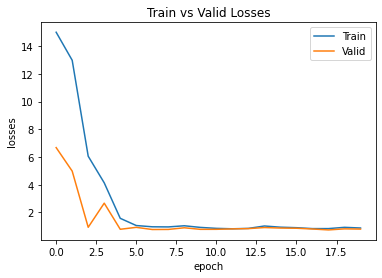

In [156]:
#@title Loss graph
def plot_loss():
  plt.plot(train_losses)
  plt.plot(eval_losses)
  plt.xlabel('epoch')
  plt.ylabel('losses')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Losses')
  plt.show()

plot_loss()

In [157]:
#@title getting the shapely values
%%capture
shap.initjs()
train_dataloader = DataLoader(dataset_train, batch_size=80)
test_dataloader = DataLoader(dataset_test, batch_size=20)
batch = next(iter(train_dataloader))
data_train, _ = batch
batch = next(iter(test_dataloader))
data_test, _ = batch
explainer = shap.DeepExplainer(model, data_train)
shap_values = explainer.shap_values(data_test)


In [158]:
#@title SHAP force plot
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

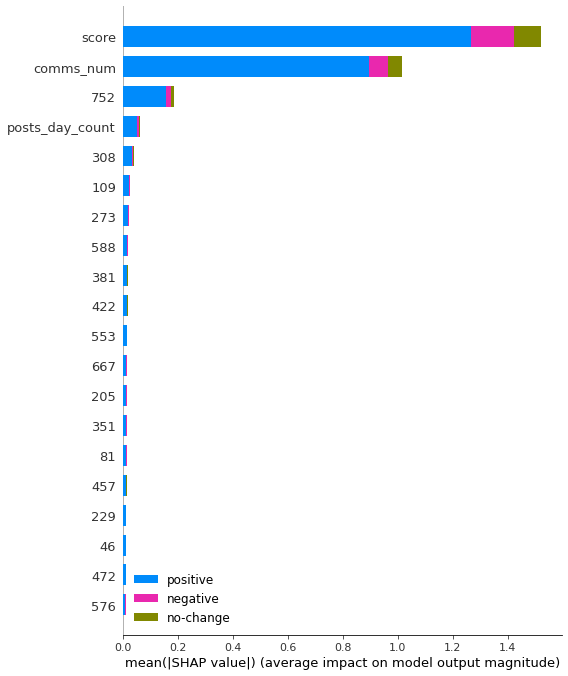

In [159]:
#@title SHAP summary plot
shap.summary_plot(shap_values = shap_values, features = X_train.columns, class_names = ['no-change', 'negative','positive'])

###We can see that the KNN classifier and the DNN have similar results (about 75~80%). But, the DNN is less consistent than the KNN(sometimes more ten 80% and sometimes 70%). In some runs, it probably reaches a local minimum. Generally, the DNN should have better results than classic competitors. In our case, after aggregating the data by days, we only have a small number of samples. Therefore, it cannot be considered superior in this case. 

By the SHAP explanations, we can see that in both classifiers the most relevant features are the normalized score and number of comments per post. This is followed by, with lesser influence, the number of posts in the day.  

It is worth pointing out that 28.57 % of the data fell on weekends when the trade is closed and we don't have PC values. We tried to use Monday's PC for every NA value on Sunday and Saturday. However, it damaged the results of the models (falling into a random classifier's results). Therefore, we just omitted those days and concluded we can't use the traffic over Reddit for forecasting more than one day ahead.

In conclusion, we can see encouraging results from the GME models. The 80% rate is 30% higher than a random classifier and 20% higher than the majority classifier (60% of the time predicts negative, 40% positive). There are several ways we can try to improve the results. There is, however, a possibility that as a result of the nature of Stokes's values, there is only partial causality between Reddit posts and stock values. This is because we can't improve the results very much from 80%.


###applying the best models from GME over AMC and NOK

Next, to demonstrate that Reddit's connection with stock value isn't limited to GME, we will apply the DNN and KNN models over AMC and NOK.

####AMC prediction

#####KNN

In [172]:
#@title dataframe for classification

cls_df = day_AMC_df.dropna().copy(deep=True)
cls_df['PC']= cls_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
cls_df.drop(['timestamp'], axis=1, inplace=True)
cls_df.dropna(inplace=True)
x = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
cls_df.sample(n=4)

score   comms_num  posts_day_count        PC  sentiment    tf-idf  \
28  1036.068966  102.896552            545.0  negative          4  4.623044   
98   208.000000   61.500000            105.0  positive          2  4.869413   
95   490.333333  126.666667             61.0  negative          2  5.708436   
61   552.333333  106.000000             84.0  negative          2  6.261052   

           0         1         2         3  ...       758       759       760  \
28 -2.588746 -2.314904  3.506288 -4.188915  ...  1.207525 -6.079026 -0.315500   
98 -0.450946 -0.675047  0.130000 -0.037181  ...  0.003270 -0.370409  0.246981   
95 -0.372409 -0.492616 -0.043891  0.307827  ... -0.199642 -0.044635  0.126629   
61 -1.094384 -0.645457  0.354733  0.053631  ...  0.533708 -0.526672  1.028966   

         761       762       763       764       765        766       767  
28 -3.350657  7.368499  0.586005 -5.371938 -9.855352  11.338819  9.216066  
98 -0.741051  0.430249  0.359668 -0.948969 -0.600872   0.469817  0.188737  
95  0.360556  1.155856  0.182398 -0.418448 -1.064530   1.277465 -0.122391  
61  0.196666  0.336537  0.460622 -1.044093 -0.166178   1.372308  0.653538  

[4 rows x 774 columns]

In [173]:
#@title KNN results

knn = KNeighborsClassifier(8)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5833333333333334

#####DNN

In [174]:
#@title Adding the embedding features to the data frame 
AMC_embedding_df = pd.concat([AMC_df, pd.DataFrame(AMC_embeddings)], axis=1)
AMC_embedding_df.name = 'AMC'
AMC_embedding_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/AMC_embedding_df.pkl')
day_AMC_df = AMC_embedding_df.groupby('timestamp', as_index=False).sum()
y = AMC_df.groupby('timestamp', as_index=False)[['score','comms_num','posts_day_count','PC','tf-idf']].count().drop(columns='timestamp')
day_AMC_df[['score','comms_num','posts_day_count','PC','tf-idf']] = day_AMC_df[['score','comms_num','posts_day_count','PC','tf-idf']].div(y)
day_AMC_df.name = AMC_embedding_df.name
day_before_AMC = day_AMC_df.copy()
day_before_AMC['PC']  = day_before_AMC['PC'].shift(-1)
day_before_AMC.drop(['timestamp'],axis=1, inplace=True)

cls_df = day_before_AMC.dropna().copy(deep=True).astype(np.float32)
cls_df['PC']= cls_df['PC'].apply(lambda x: 0 if x>0 else 1 if x<0 else 2 if x==0 else None)
cls_df.dropna(inplace=True)
X = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
cls_df.sample(n=4)


score   comms_num  posts_day_count  PC  sentiment     tf-idf  \
34    777.000000  120.434784            589.0   1        7.0   4.583251   
90    581.000000  248.000000             48.0   1        0.0  17.835926   
87   3045.666748  292.666656            112.0   2        1.0   4.011236   
124   315.125000  627.750000            169.0   1        6.0   8.979706   

            0         1         2         3  ...       758       759  \
34  -3.036985 -0.263422  0.064772 -3.437074  ...  2.716704 -3.578481   
90  -0.629564 -0.224241  0.382611 -0.208472  ...  0.214932  0.075411   
87  -0.103427 -0.046437  0.892888 -0.637409  ... -0.391120 -0.180206   
124 -3.505333 -1.181360  1.740939 -0.112380  ...  1.016500 -1.816993   

          760       761       762       763       764       765       766  \
34   0.164922 -3.750139  2.657646  0.223568 -3.607747 -9.947790  6.262269   
90   0.095935 -0.201962  0.275347 -0.305084 -0.331456 -0.073609  0.344014   
87   0.552264 -0.131464  0.487127  0.131561 -0.540473 -1.274114  1.131062   
124  0.691666 -1.121389  3.664602 -0.469871 -3.167104 -5.621249  5.263805   

          767  
34   7.915597  
90   0.459328  
87   0.689743  
124  5.301061  

[4 rows x 774 columns]

Again- we take all the posts bert embeddings, and we sum them up into one vector for each day (line 3 in the code above).

In [175]:
#@title Training the model 

dataset_train = StocksDataset(X_train ,y_train)
dataset_test = StocksDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=4)
test_dataloader = DataLoader(dataset_test, batch_size=4)

model = nn.Sequential(
    nn.Linear(773,1000),
    nn.ReLU(),
    nn.Linear(1000,100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100,3),
    nn.LogSoftmax(dim=1) 
    )

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())
error = nn.CrossEntropyLoss()
num_epochs = 20
train_losses=[]
eval_losses=[]
correct = 0
total = 0
best_accu = 0
for epoch in range(1,num_epochs+1): 
  train(epoch)
  best_accu = max(test(epoch), best_accu)


Epoch : 1


100%|██████████| 6/6 [00:00<00:00, 764.04it/s]


Test Loss: 3.586 | Test Accuracy: 66.667

Epoch : 2


100%|██████████| 6/6 [00:00<00:00, 811.09it/s]


Test Loss: 3.061 | Test Accuracy: 54.167

Epoch : 3


100%|██████████| 6/6 [00:00<00:00, 646.60it/s]


Test Loss: 2.693 | Test Accuracy: 41.667

Epoch : 4


100%|██████████| 6/6 [00:00<00:00, 666.43it/s]


Test Loss: 1.213 | Test Accuracy: 66.667

Epoch : 5


100%|██████████| 6/6 [00:00<00:00, 818.48it/s]


Test Loss: 0.828 | Test Accuracy: 41.667

Epoch : 6


100%|██████████| 6/6 [00:00<00:00, 544.92it/s]


Test Loss: 1.262 | Test Accuracy: 45.833

Epoch : 7


100%|██████████| 6/6 [00:00<00:00, 686.04it/s]


Test Loss: 0.990 | Test Accuracy: 58.333

Epoch : 8


100%|██████████| 6/6 [00:00<00:00, 765.66it/s]


Test Loss: 0.778 | Test Accuracy: 66.667

Epoch : 9


100%|██████████| 6/6 [00:00<00:00, 894.53it/s]


Test Loss: 0.864 | Test Accuracy: 62.500

Epoch : 10


100%|██████████| 6/6 [00:00<00:00, 904.30it/s]


Test Loss: 0.863 | Test Accuracy: 33.333

Epoch : 11


100%|██████████| 6/6 [00:00<00:00, 828.67it/s]


Test Loss: 1.139 | Test Accuracy: 66.667

Epoch : 12


100%|██████████| 6/6 [00:00<00:00, 695.69it/s]

Test Loss: 0.984 | Test Accuracy: 45.833



Epoch : 13


100%|██████████| 6/6 [00:00<00:00, 662.78it/s]


Test Loss: 0.955 | Test Accuracy: 66.667

Epoch : 14


100%|██████████| 6/6 [00:00<00:00, 622.27it/s]


Test Loss: 0.810 | Test Accuracy: 66.667

Epoch : 15


100%|██████████| 6/6 [00:00<00:00, 588.69it/s]


Test Loss: 0.738 | Test Accuracy: 62.500

Epoch : 16


100%|██████████| 6/6 [00:00<00:00, 687.59it/s]


Test Loss: 0.719 | Test Accuracy: 70.833

Epoch : 17


100%|██████████| 6/6 [00:00<00:00, 547.93it/s]


Test Loss: 0.748 | Test Accuracy: 66.667

Epoch : 18


100%|██████████| 6/6 [00:00<00:00, 646.94it/s]


Test Loss: 0.743 | Test Accuracy: 66.667

Epoch : 19


100%|██████████| 6/6 [00:00<00:00, 701.74it/s]


Test Loss: 0.720 | Test Accuracy: 66.667

Epoch : 20


100%|██████████| 6/6 [00:00<00:00, 688.61it/s]


Test Loss: 0.726 | Test Accuracy: 66.667


In [176]:
#@title Test Best Accuracy
model.load_state_dict(torch.load('./model_weights'))
print(best_accu)

70.83333333333333


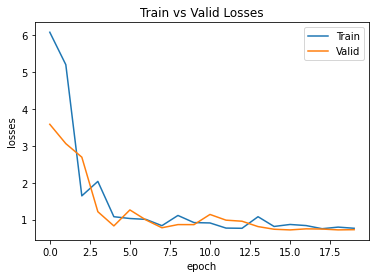

In [177]:
#@title Loss graph
def plot_loss():
  plt.plot(train_losses)
  plt.plot(eval_losses)
  plt.xlabel('epoch')
  plt.ylabel('losses')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Losses')
  plt.show()

plot_loss()

####NOK prediction

#####KNN

In [178]:
#@title dataframe for classification

cls_df = day_NOK_df.dropna().copy(deep=True)
cls_df['PC']= cls_df['PC'].apply(lambda x: 'positive' if x>0 else 'negative' if x<0 else 'no change' if x==0 else None)
cls_df.drop(['timestamp'], axis=1, inplace=True)
cls_df.dropna(inplace=True)
x = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
cls_df.sample(n=4)

score   comms_num  posts_day_count        PC  sentiment    tf-idf  \
91  945.000000  315.000000            179.0  negative          1  3.825458   
13  644.666667  152.500000            222.0  negative          2  3.984293   
21  151.000000   44.600000            347.0  negative         -1  3.496153   
12  426.333333  116.333333            148.0  negative          1  5.826852   

           0         1         2         3  ...       758       759       760  \
91 -0.493226 -0.249731  0.012744  0.047853  ...  0.021957  0.107101 -0.101264   
13 -1.722742 -0.779625 -0.242045 -0.514256  ...  0.426520 -0.731386  0.181693   
21 -0.746284  0.634509  0.334488 -0.565036  ... -0.115730 -1.524927  0.531824   
12 -0.737729 -0.199324 -0.516895  0.021151  ...  0.172587  0.012531  0.013873   

         761       762       763       764       765       766       767  
91 -0.279883 -0.290319 -0.338882 -0.532720 -0.363785  0.350029  0.079616  
13 -0.462933  1.049557 -0.766258 -0.931548 -1.145807  1.781306  1.979975  
21 -0.365344  1.046521  0.236740 -0.680736 -0.877095  1.512058  2.087949  
12 -0.166310  1.218302  0.003778 -0.757742 -1.059044  0.439472  1.808878  

[4 rows x 774 columns]

In [179]:
#@title KNN results

knn = KNeighborsClassifier(3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.5625

#####DNN

In [180]:
#@title Adding the embedding features to the data frame 
NOK_embedding_df = pd.concat([NOK_df, pd.DataFrame(NOK_embeddings)], axis=1)
NOK_embedding_df.name = 'NOK'
AMC_embedding_df.to_pickle(path='/content/drive/MyDrive/memeStocksData/NOK_embedding_df.pkl')
day_NOK_df = NOK_embedding_df.groupby('timestamp', as_index=False).sum()
y = NOK_df.groupby('timestamp', as_index=False)[['score','comms_num','posts_day_count','PC','tf-idf']].count().drop(columns='timestamp')
day_NOK_df[['score','comms_num','posts_day_count','PC','tf-idf']] = day_NOK_df[['score','comms_num','posts_day_count','PC','tf-idf']].div(y)
day_NOK_df.name = NOK_embedding_df.name
day_before_NOK = day_NOK_df.copy()
day_before_NOK['PC']  = day_before_NOK['PC'].shift(-1)
day_before_NOK.drop(['timestamp'],axis=1, inplace=True)

cls_df = day_before_NOK.dropna().copy(deep=True).astype(np.float32)
cls_df['PC']= cls_df['PC'].apply(lambda x: 0 if x>0 else 1 if x<0 else 2 if x==0 else None)
cls_df.dropna(inplace=True)
X = cls_df.drop(['PC'], axis=1)
y = cls_df['PC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
cls_df.sample(n=4)


score   comms_num  posts_day_count  PC  sentiment    tf-idf  \
4   2416.289551  298.657898            884.0   1        3.0  4.966567   
10    60.444443   26.888889            511.0   1        2.0  4.634769   
76   272.000000   59.000000             73.0   1        0.0  3.814869   
57   175.000000   60.000000            122.0   0        2.0  4.996192   

           0         1         2         3  ...       758       759       760  \
4  -6.779595 -0.066967 -0.317854 -4.159831  ...  1.390761 -5.019012  1.485036   
10 -1.256633 -0.028299  0.813789 -0.783558  ... -0.762096 -1.060121  0.082309   
76 -0.413048 -0.132762  0.134891 -0.085224  ...  0.343770 -0.313487  0.325297   
57 -0.505803 -0.104119  0.124530 -0.449973  ...  0.394748 -0.367908  0.423865   

         761       762       763       764        765        766        767  
4  -3.755981  6.185140  2.043890 -8.509636 -13.120497  10.331371  17.475510  
10 -0.212091  2.480542  0.082636 -3.266358  -2.519652   2.945741   3.465607  
76 -0.025523  0.433079 -0.032764 -0.150550  -0.154461   0.137335  -0.124599  
57  0.092006  0.878595 -0.308083 -0.589309  -0.660499   0.656546   0.569297  

[4 rows x 774 columns]

In [181]:
#@title Training the model 

dataset_train = StocksDataset(X_train ,y_train)
dataset_test = StocksDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=4)
test_dataloader = DataLoader(dataset_test, batch_size=4)

model = nn.Sequential(
    nn.Linear(773,1000),
    nn.ReLU(),
    nn.Linear(1000,100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100,3),
    nn.LogSoftmax(dim=1) 
    )

loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters())
error = nn.CrossEntropyLoss()
num_epochs = 20
train_losses=[]
eval_losses=[]
correct = 0
total = 0
best_accu = 0
for epoch in range(1,num_epochs+1): 
  train(epoch)
  best_accu = max(test(epoch), best_accu)


Epoch : 1


100%|██████████| 4/4 [00:00<00:00, 708.08it/s]


Test Loss: 0.932 | Test Accuracy: 75.000

Epoch : 2


100%|██████████| 4/4 [00:00<00:00, 522.75it/s]


Test Loss: 0.749 | Test Accuracy: 62.500

Epoch : 3


100%|██████████| 4/4 [00:00<00:00, 626.06it/s]


Test Loss: 0.770 | Test Accuracy: 68.750

Epoch : 4


100%|██████████| 4/4 [00:00<00:00, 701.74it/s]


Test Loss: 0.926 | Test Accuracy: 43.750

Epoch : 5


100%|██████████| 4/4 [00:00<00:00, 518.25it/s]


Test Loss: 0.734 | Test Accuracy: 56.250

Epoch : 6


100%|██████████| 4/4 [00:00<00:00, 662.84it/s]


Test Loss: 0.712 | Test Accuracy: 62.500

Epoch : 7


100%|██████████| 4/4 [00:00<00:00, 747.95it/s]


Test Loss: 0.679 | Test Accuracy: 43.750

Epoch : 8


100%|██████████| 4/4 [00:00<00:00, 837.06it/s]


Test Loss: 0.859 | Test Accuracy: 37.500

Epoch : 9


100%|██████████| 4/4 [00:00<00:00, 591.96it/s]


Test Loss: 0.676 | Test Accuracy: 50.000

Epoch : 10


100%|██████████| 4/4 [00:00<00:00, 470.00it/s]


Test Loss: 0.609 | Test Accuracy: 75.000

Epoch : 11


100%|██████████| 4/4 [00:00<00:00, 724.94it/s]


Test Loss: 0.629 | Test Accuracy: 68.750

Epoch : 12


100%|██████████| 4/4 [00:00<00:00, 425.05it/s]


Test Loss: 0.621 | Test Accuracy: 68.750

Epoch : 13


100%|██████████| 4/4 [00:00<00:00, 463.24it/s]


Test Loss: 0.674 | Test Accuracy: 62.500

Epoch : 14


100%|██████████| 4/4 [00:00<00:00, 510.01it/s]


Test Loss: 0.751 | Test Accuracy: 37.500

Epoch : 15


100%|██████████| 4/4 [00:00<00:00, 528.73it/s]


Test Loss: 0.735 | Test Accuracy: 43.750

Epoch : 16


100%|██████████| 4/4 [00:00<00:00, 679.79it/s]


Test Loss: 0.586 | Test Accuracy: 68.750

Epoch : 17


100%|██████████| 4/4 [00:00<00:00, 491.14it/s]


Test Loss: 0.569 | Test Accuracy: 75.000

Epoch : 18


100%|██████████| 4/4 [00:00<00:00, 631.84it/s]


Test Loss: 0.707 | Test Accuracy: 37.500

Epoch : 19


100%|██████████| 4/4 [00:00<00:00, 545.18it/s]


Test Loss: 0.655 | Test Accuracy: 62.500

Epoch : 20


100%|██████████| 4/4 [00:00<00:00, 762.22it/s]

Test Loss: 0.604 | Test Accuracy: 75.000


In [182]:
#@title Test Best Accuracy
model.load_state_dict(torch.load('./model_weights'))
print(best_accu)

75.0


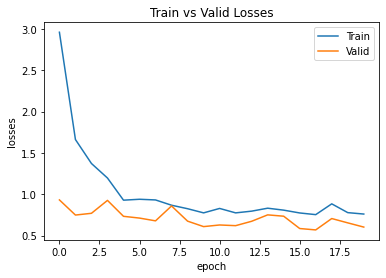

In [183]:
#@title Loss graph
def plot_loss():
  plt.plot(train_losses)
  plt.plot(eval_losses)
  plt.xlabel('epoch')
  plt.ylabel('losses')
  plt.legend(['Train','Valid'])
  plt.title('Train vs Valid Losses')
  plt.show()

plot_loss()

###We can see that only the DNN model is still relevant (with a beet lesser results of 70~75%). 
In comparison to GME, it is possible that AMC and NOK stocks have a less powerful connection to posts on Reddit. We used the features from BERT only with the DNN classifier (the simple one couldn't handle the number of features and dropped results). Perhaps this explains why DNN performs better than KNN with AMC and NOK (the connections are more relaxed and the BERT model is more essential).

##Conclusion

In this project, we discussed the connections between trends on the social media platform - Reddit and specific "meme stocks" values (GME, AMC, and NOK). We used a premade Kaggle dataset and processed it to our needs by hard-coded actions and premade models such as FB prophet, VADER, Doc2Vec, and BERT. We defined the question for the project - **whether we can predict the price changes trend of the stock tomorrow based on today's data** (if it going to rise, decline, or stay the same)
after a vast EDA, evaluation, and comparison of several models and features we finished with the following model:

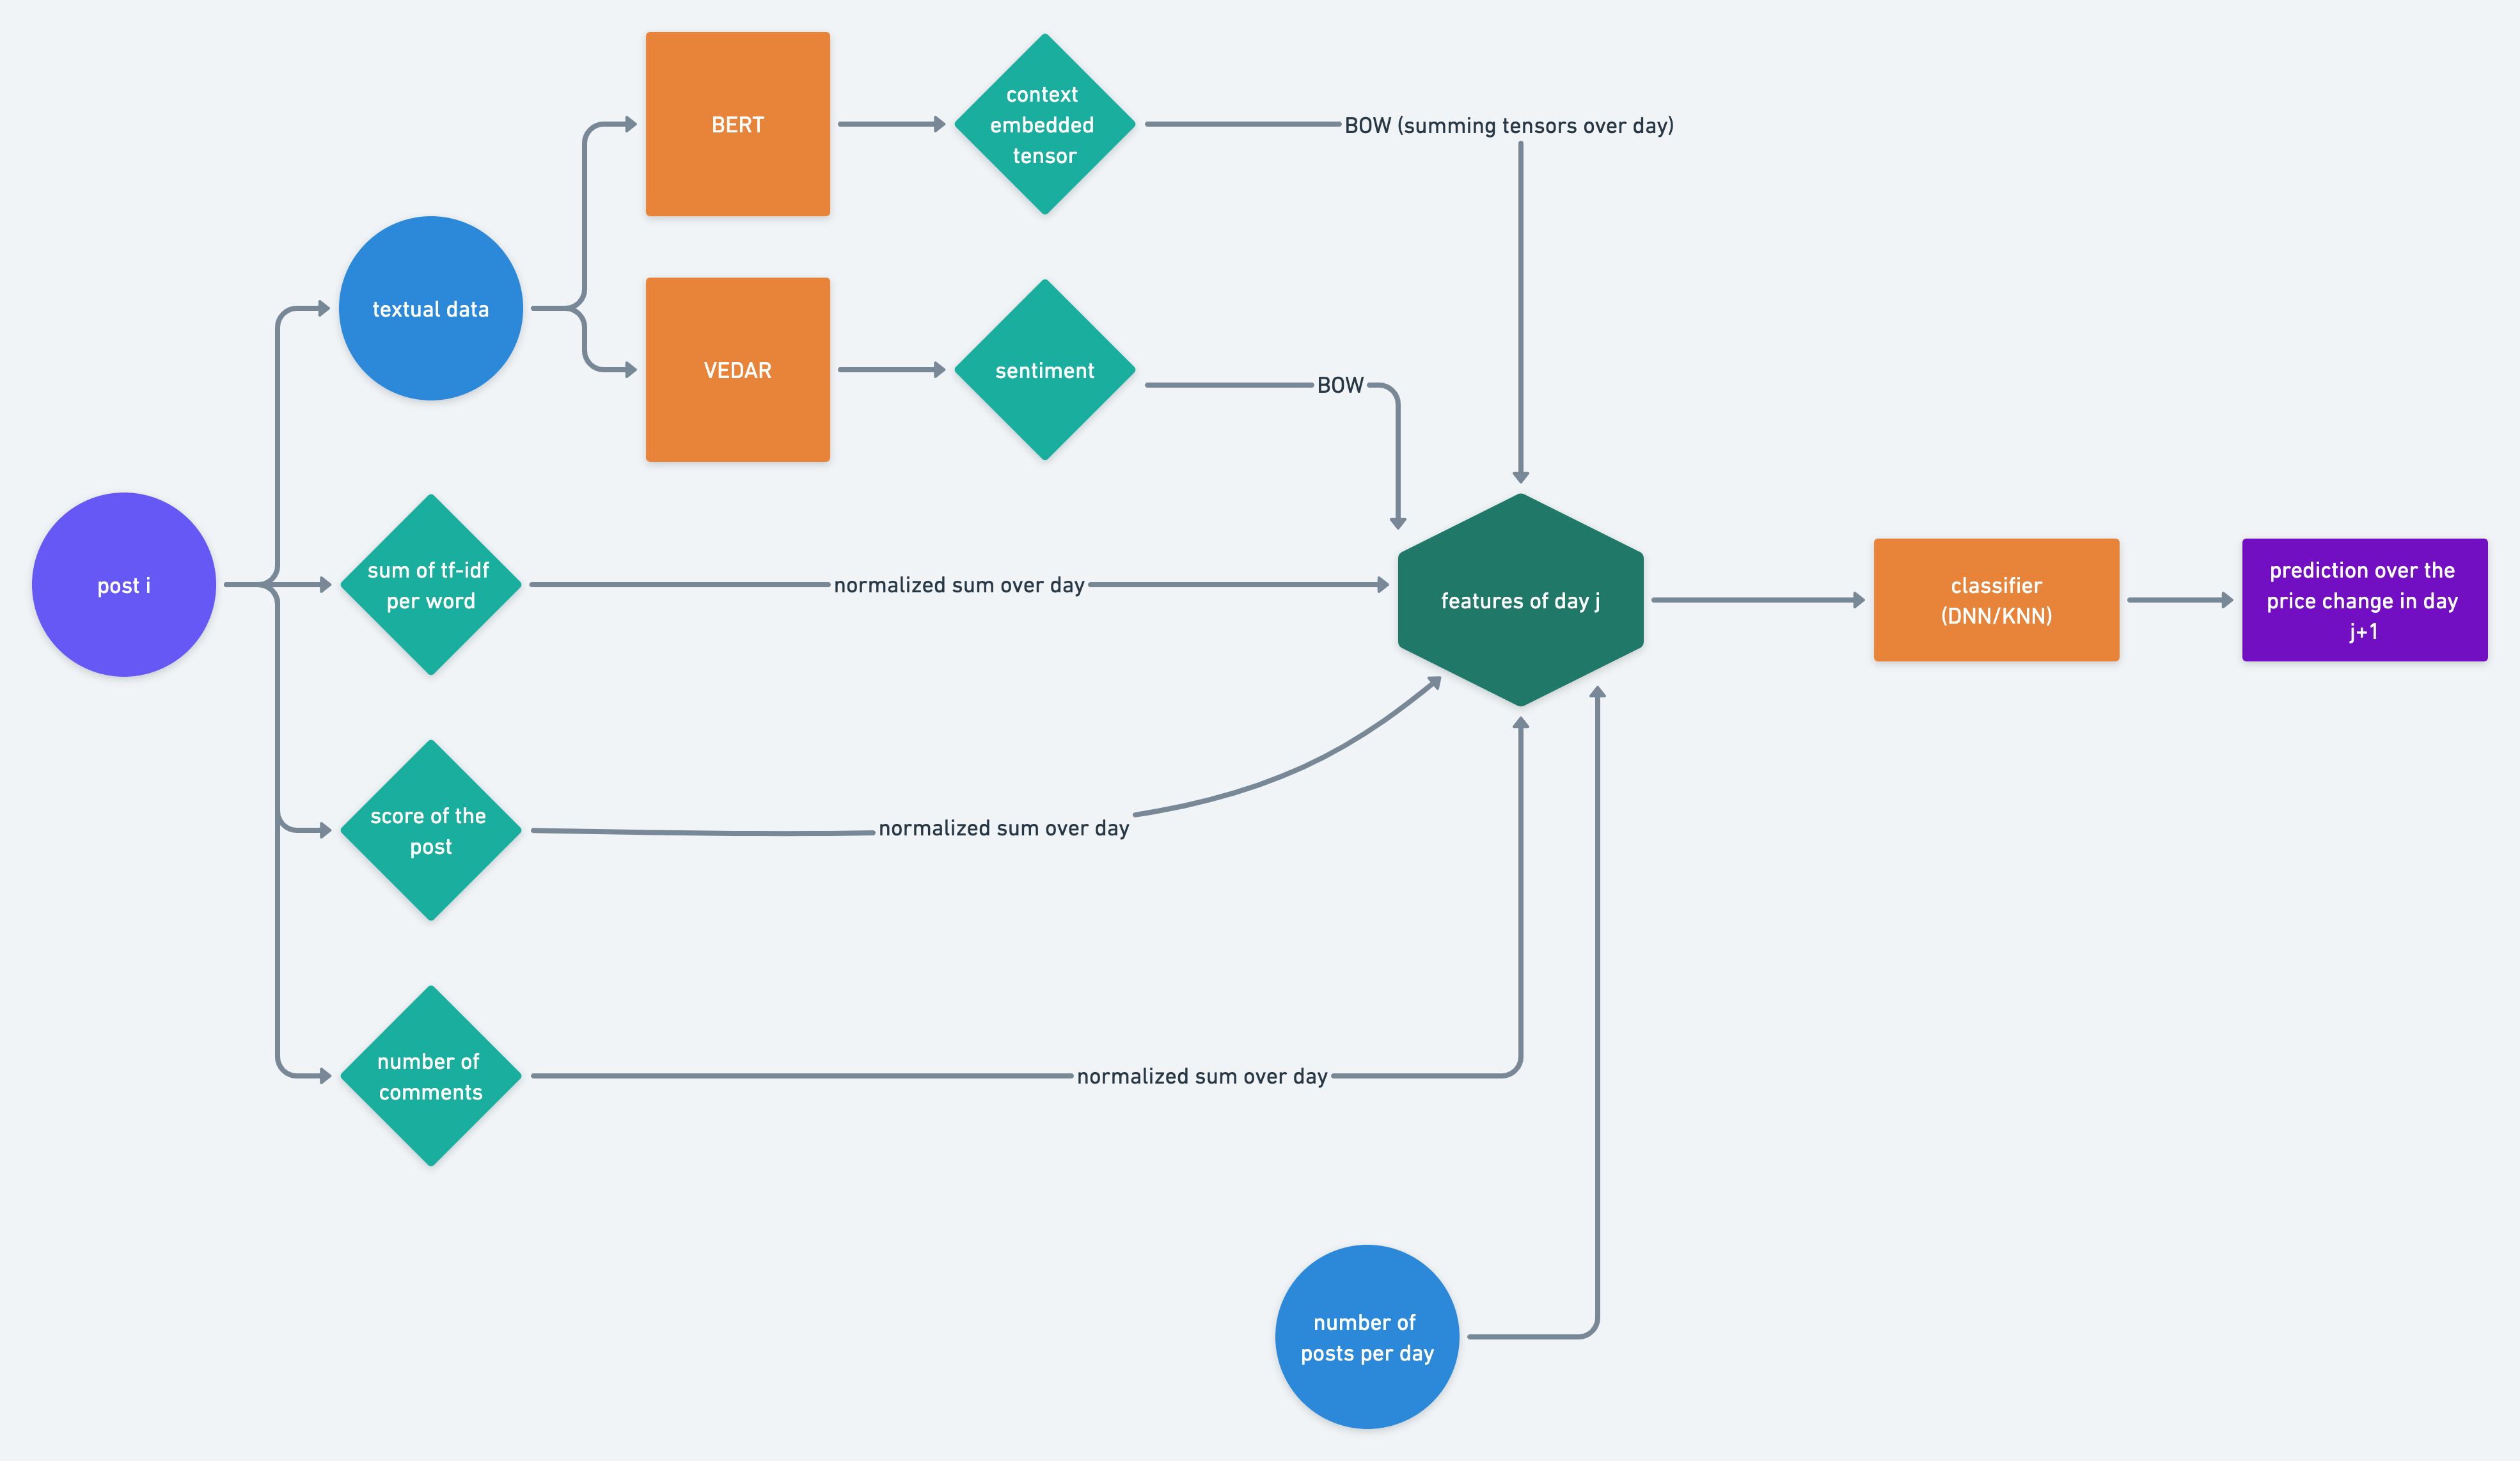

###We achieved several main conclusions in the project:


1. At the specific time (after the GME short squeeze and with high liquidity in the stock markets), we obtained prediction results that were better than the random classifier (by 20%-30%) over 3 of the most significant meme stocks.
2. The most successful results have been obtained with GME. We can't say for certain if it is because of more data about stock or because it has a better correlation with Reddit traffic.
3. Results were achieved only with predictions made one day in advance. When trying to use the weekend data (only posts with no stocks traded) over 2-3 days in advance, the models have failed.
4. The best-premade model we have used over the textual information of the posts was Google's BERT. SHAP results showed it to be significant for prediction.

###If we had more time to continue with this project we would have invested it in several actions and open questions:

1. Training the BERT weights. BERT wasn't trained with emoji samples as words. Because the Reddit posts are characterized by many emojis that have a significant role in the meaning of the sentence, we have a reason to believe that by continuing our training with the posts we can achieve better results.
2. To aggregate the features BERT brought over all the posts in one day we used BOW (summing them). In this method, we lose the meaning of the sequence of posts in the day. So, we believe that by applying a transformer like BERT over the BERT features of every post we can achieve better results in the predictions.
3. We would have tried more actions for using the data from the weekends. Now we just throw 2/7 of the data and it's a waste that could have improved our results.
4.  We would have liked to check our models over other stocks and timeframes. We show with the FB prophet that the GME short squeeze was a significant event that changed the behavior of the data. It would be interesting to check our models over the time previous to it.
5.  The Reddit posts have much more information than the textual ones and the metadata. Through computer vision and data mining, we can extract many more features from the likes attached to the posts, the pictures, and the videos.

All that said, it's important to point out that the stock market is a complex area. Therefore, the information from Reddit may have only a limited correlation with the stock price changes, and the results we can achieve with further research are limited and not much higher than the ones we had achieved.
